<center>
<img src="../../img/ods_stickers.jpg" />
    
## [mlcourse.ai](https://mlcourse.ai) – Open Machine Learning Course 

<center >Author: Denis Mironov (@dmironov)

# <center>Forecasting stock returns with ARIMA, and prices with Ridge and Lasso  </center>

## 1. Feature and data explanation

### 1.1  Description of the task

In the project, we are analyzing five assets: 
                                                              
    - Barrick Gold Corporation (ABX)                     Basic Industries
    - Walmart Inc. (WMT)                                 Consumer Services
    - Caterpillar Inc (CAT)                              Capital Goods
    - BP p.l.c. (BP)                                     Energy
    - Ford Motor Company (F)                             Capital Goods 
    - General Electric Company (GE)                      Energy 
    
based on Yahoo Finance (https://finance.yahoo.com) data. In order to reproduce the results of the project, the data for the assets should be either collected manually from Yahoo Finance for the daily time-period from the 10th of December 2013 to 7th of December 2018 or be downloaded here  https://github.com/dmironov1993/Data

In this project, our goal is to predict stock returns with Autoregressive Integrated Moving Average (ARIMA) model and stock prices with Ridge and Lasso. ARIMA model is defined by three parameters $(p,d,q)$, where $p$ - the order of the autoregressive model, $d$ - the degree of differencing and $q$ - the order of the moving-average model. The choice of these parameters is done by brute-forcing (grid search) and choosing the model with the lowest Akaike Information Criterion. If time-series is stationary, we are left with p and q parameters, while $d=0$. Such a model is usually called ARMA, and we use this abbreviation hereinafter. However, since Python does not have several important libraries as those in R, for instance the libraries for ARMA-GARCH simultaneous analysis, stock prices will be predicted as well by using machine learning (ML) algorithms such as Ridge and Lasso. At the appropriate stage of our work, we will generate additional features. ML algorithms will be tuned by using grid search of hyperparameters. The performance of ML algorithms will be tested on a houldout sample. 

### 1.2. Libraries and Dataset

Here we import libraries and load the data in a CSV form which we are going to analysis and working with.

In [1]:
# Jupiter notebook setup and Importing libraries 
# By default, all figures are shown in 'png'. If the latter is changed to 'svg', higher quality is guaranteed
%config InlineBackend.figure_format = 'png'
import warnings
warnings.simplefilter('ignore')

# Data manipulations
import pandas as pd
import numpy as np

# Visualization
import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import plotly
import plotly.graph_objs as go
from plotly import tools
import plotly.plotly as py
init_notebook_mode(connected=True)

# ARIMA (ARMA) modelling
import statsmodels.api as sm
import statsmodels.tsa.api as smt
import statsmodels.tsa.stattools as ts

# Statistics
import scipy.stats as scs
from scipy.stats import skew
from scipy.stats import kurtosis
from statsmodels.tsa.stattools import kpss

# Ljung-box test (to check whether residuals are white noise)
from statsmodels.stats.diagnostic import acorr_ljungbox


# Metrics for ML (ARIMA/ARMA has embedded AIC criterion)
from sklearn.metrics import mean_absolute_error

# Hyperparameter tuning and validation
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit 
from sklearn.preprocessing import StandardScaler

# Machine learning algorithms
#from sklearn.linear_model import LassoCV, RidgeCV
from sklearn.linear_model import Ridge, Lasso

In [2]:
# Symbols of assets
asset_names = ['ABX','WMT','CAT','BP','F','GE']

In [3]:
# function for loading csv
def read_csv(symbols):
    
    """ 
        reading csv file
        
        Input: list  
           - symbols of traded stocks 
    
        Output: tuple
           - dataframes of traded stocks
    
    """
    
    ListofAssets_df = []
    for asset in symbols:
        ListofAssets_df.append(pd.read_csv('%s.csv' % asset, sep=',')\
                                  .rename(columns={'Adj Close': '%s_Adj_close' % asset})\
                                  .sort_values(by='Date', ascending=False))
        
    return tuple(ListofAssets_df)

In [4]:
# number of dataframes within read_csv
print (len(read_csv(asset_names)))

6


In [5]:
# number of rows and columns within each df
for df in read_csv(asset_names):
    print (df.shape)

(1258, 7)
(1258, 7)
(1258, 7)
(1258, 7)
(1258, 7)
(1258, 7)


In [6]:
# view of one of dataframes
read_csv(asset_names)[0].head(2)

Date   Open   High    Low  Close  ABX_Adj_close    Volume
1257  2018-12-07  13.61  13.80  13.49  13.68          13.68  20303800
1256  2018-12-06  13.18  13.48  13.11  13.37          13.37  21323800

In [7]:
# information about structure of data
read_csv(asset_names)[0].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1258 entries, 1257 to 0
Data columns (total 7 columns):
Date             1258 non-null object
Open             1258 non-null float64
High             1258 non-null float64
Low              1258 non-null float64
Close            1258 non-null float64
ABX_Adj_close    1258 non-null float64
Volume           1258 non-null int64
dtypes: float64(5), int64(1), object(1)
memory usage: 78.6+ KB


We see that there are no missing values in the datasets of our interest.

In the obtained historical prices, we have the following information for each of the asset:

 - **Date**: Date
 - **Open**: Open price within a date
 - **High**: The highest price within a date
 - **Low**: The lowest price within a date
 - **Close**: Close price within a date
 - **`NAME`_Adj_close**: Adjusted close price in the end of a date
 - **Volume**: Trading volume
 
In addition to this information, we are interested in daily returns of the assets. Here the latter will be calculated by using

   ### <center> $ r^{(i)}_{t} := ln\left(\frac{P^{(i)}_{t}}{P^{(i)}_{t-1}} \right) = ln\left( P^{(i)}_{t}\right) - ln\left( P^{(i)}_{t-1} \right),$ </center>

where $ln$ stands for natural logarithm, $P^{(i)}_{t}$ is the adjusted close price of the asset ${i}$ at the time moment ${t}$, while $P^{(i)}_{t-1}$ is at the previous moment of time: ${t-1}$.

In [8]:
# function for adding log-returns column to dataframes 
def add_log_returns(assets_df, symbols):
    
    """ 
        Calculating returns of the assets
        
        Input:
            - assets_df: is a tuple of dataframes
            - symbols: list with symbols of traded stocks in the same order as those in assets_df
        Output:
            - tuple of dataframes with returns, dataframe's index is Date now, 
              dataframe is also sorted by index in ascending order.
              
    """
    
    ListofAssets_df = []
    num_asset = 0
    
    if len(assets_df) == len(symbols):
        
        for df in assets_df:
            adj_closing_price = df['%s_Adj_close' % symbols[num_asset]]
            log_array = np.log(np.array(adj_closing_price))
            log_return_array = log_array - np.append(log_array[1:], np.nan)
            log_return_df = pd.DataFrame(log_return_array,
                                         columns=['%s_returns' % symbols[num_asset]])
            df = df.reset_index().drop(columns=['index'])
            df = pd.concat((df, log_return_df), axis=1)
            df['Date'] = df['Date'].apply(pd.to_datetime)
            df = df.set_index('Date')
            df = df.sort_index(ascending=True)
            df.dropna(axis=0, inplace=True)
            ListofAssets_df.append(df)
            num_asset += 1
            
        return tuple(ListofAssets_df)
    
    else:
        print ('Number of DataFrames and Number of assets considered should be equal')

In [9]:
asset_dfs = add_log_returns(read_csv(asset_names), asset_names)

In [10]:
# we have added returns, year, month and day columns
for df in asset_dfs:
    print (df.shape)

(1257, 7)
(1257, 7)
(1257, 7)
(1257, 7)
(1257, 7)
(1257, 7)


In [11]:
asset_dfs[0].head(3)

Open       High    Low      Close  ABX_Adj_close    Volume  \
Date                                                                          
2013-12-11  16.850000  16.879999  16.32  16.379999      15.428679  15990000   
2013-12-12  15.950000  16.510000  15.94  16.459999      15.504032  15321000   
2013-12-13  16.639999  16.980000  16.51  16.740000      15.767772  15426700   

            ABX_returns  
Date                     
2013-12-11    -0.029476  
2013-12-12     0.004872  
2013-12-13     0.016868

Now each of the dataframes, in addition to already presented six columns such as Open, High, Low, Close, NAME_Adj_close and Volume, has one additional column related to returns. Note that Date is index now rather than a column. Dataframes have been sorted by Date in ascending order. The latter is needed further for correct time series cross validation. Number of rows has been reduced to 1257 (1258 originally) since our data does not allow to calculate returns before 11th of December 2013.

For convenience, we present two functions. One to create a dataframe consisting of only adjusted close prices of our assets, while the other one is to create a dataframe consisting of only asset returns.

In [12]:
def asset_adj_close(list_of_df, symbols):
    """
    
        Input:
            - list_of_df: list of dataframes. Each of the latter should have 
              a column corresponding to adjusted close price
            - symbols: list of asset symbols taken from a stock market
        Output: 
            - pandas dataframe consisting of only adjusted close prices of considered assets
    
    """
    
    adj_close = []
    number = 0
    for asset in asset_names:
        df = list_of_df[number]['%s_Adj_close' % asset]
        adj_close.append(df)
        number += 1
        
    return pd.concat(adj_close, axis=1)

In [13]:
adj_close = asset_adj_close(asset_dfs, asset_names)
adj_close.head(2)

ABX_Adj_close  WMT_Adj_close  CAT_Adj_close  BP_Adj_close  \
Date                                                                    
2013-12-11      15.428679      69.464432      71.602913     34.299854   
2013-12-12      15.504032      68.946243      71.846390     33.910583   

            F_Adj_close  GE_Adj_close  
Date                                   
2013-12-11    13.081720     22.148977  
2013-12-12    13.065777     22.115643

In [14]:
def asset_returns(list_df, symbols):
    """
    
        Input: 
            - list_df: list of dataframes each of which contains asset returns column
            - symbols: list of asset symbols taken from a stock market
        Output: 
            - a dataframe consisting of only asset returns

    """
    
    asset_returns = []
    k = 0
    for asset in symbols:
        asset_returns.append(list_df[k]['%s_returns' % asset])
        k += 1

    return pd.concat(asset_returns, axis=1)

In [15]:
returns = asset_returns(asset_dfs, asset_names)

In [16]:
returns.head(2)

ABX_returns  WMT_returns  CAT_returns  BP_returns  F_returns  \
Date                                                                       
2013-12-11    -0.029476     0.000127    -0.013279    0.002787  -0.007286   
2013-12-12     0.004872    -0.007488     0.003395   -0.011414  -0.001219   

            GE_returns  
Date                    
2013-12-11   -0.020850  
2013-12-12   -0.001506

Next we perform primary visual data analysis of adjusted close prices and returns.

## 2. Primary data analysis, Primary visual data analysis, Insights and found dependencies

The structure of this section as follows

- Correlation and Pairplot
- A normal quantile-quantile plot and Comparison of their Kernel Density Estimation (KDE) to the closest parametric normal distribution
- Skewness, Kurtosis, Max value, Min value, Mean and Variance
- Box plot
- Time Series plot
- Correlation function and Partial correlation function

### 2.1.  Correlation and Pairplot

Here we provide a correlation table and a scatter plot against each other for both prices and returns of Barrick Gold Corporation (ABX), Walmart Inc. (WMT), Caterpillar Inc (CAT), BP p.l.c. (BP), Ford Motor Company (F) and General Electric Company (GE). Comparison of Pearson and Spearman correlations let us know the affection of large outliers on general picture of the assets movement.

First we present two auxiliary functions

In [17]:
def corr_plot(df, symbols, days=252, title='Returns'):
    
    """
        Input: 
            - df: a dataframe consisting only of data which correlations will be plotted
            - symbols: a list of the companies stocks names
            - days: represent the number of days to the past, set it to 0 to get consider the whole range
            - title: the plot title in accordance with df
        Output: 
            - illustration of assets correlations
    
    """
    
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20,8))
    sns.heatmap(df[-days:].corr(method='pearson'), annot=True, fmt='.2f', cmap="YlGnBu",
                xticklabels=symbols, yticklabels=symbols, ax=axes[0])
    sns.heatmap(df[-days:].corr(method='spearman'), annot=True, fmt='.2f', cmap="YlGnBu",
                xticklabels=symbols, yticklabels=symbols, ax=axes[1])
    axes[0].set_title('Pearson correlation (%s)' % title)
    axes[1].set_title('Spearman correlation (%s)' % title)
    plt.show()

In [18]:
def pairplot(df, days=252, width=9, height=9):
    
    """
        Input:
            - df: a dataframe consisting only of data which will be plotted
            - width and height: a corresponding size of the plot
        Output: 
            - illustration of assets pairplot
    
    """
    g = sns.pairplot(df[-days:]);
    g.fig.set_size_inches(width,height)
    plt.show()

---

#### 2.1.1 Asset Returns 

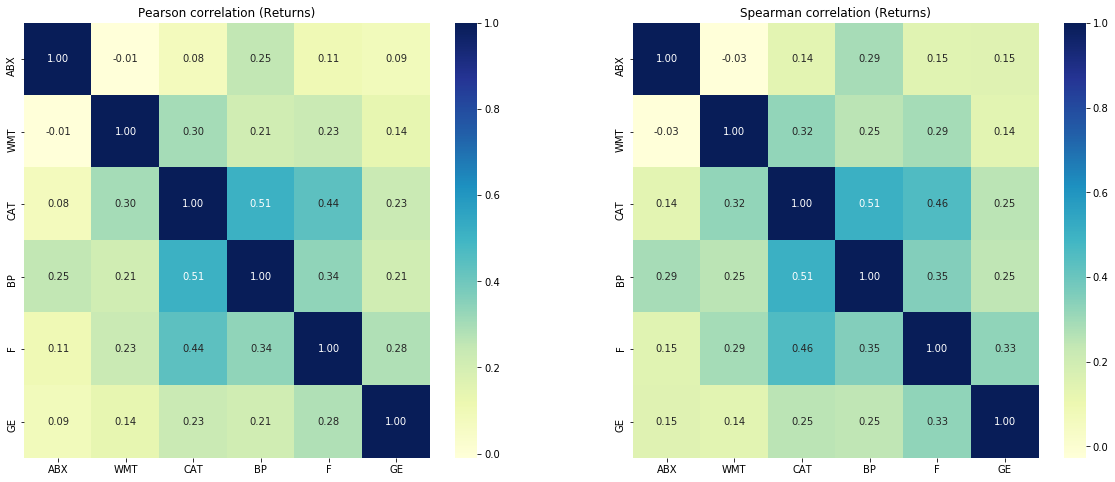

In [19]:
corr_plot(returns, asset_names, title='Returns')

From the figure right above one can see that correlation between asset returns does not change much between two types of correlations. The returns tend to comoving within 252 days time interval.

Now let's take a look at the whole picture of pair-correlations.

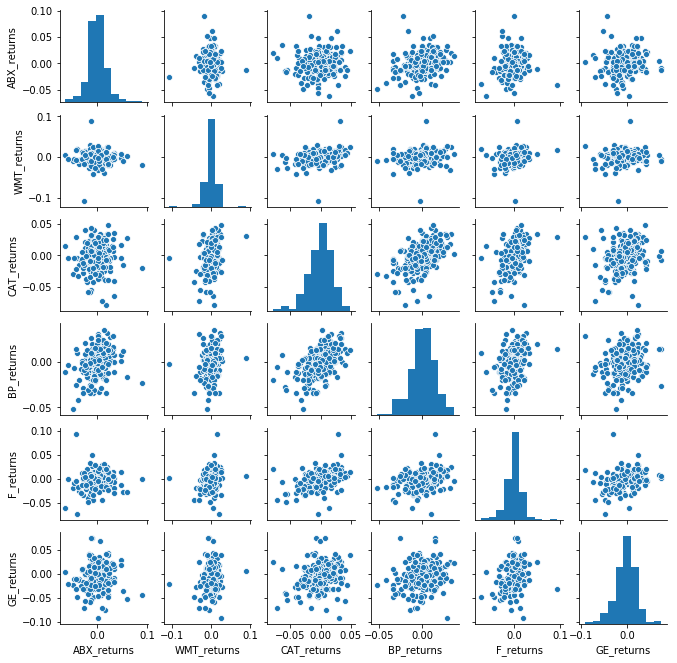

In [20]:
pairplot(returns, width=9, height=9)

#### 2.1.2 Asset Prices 

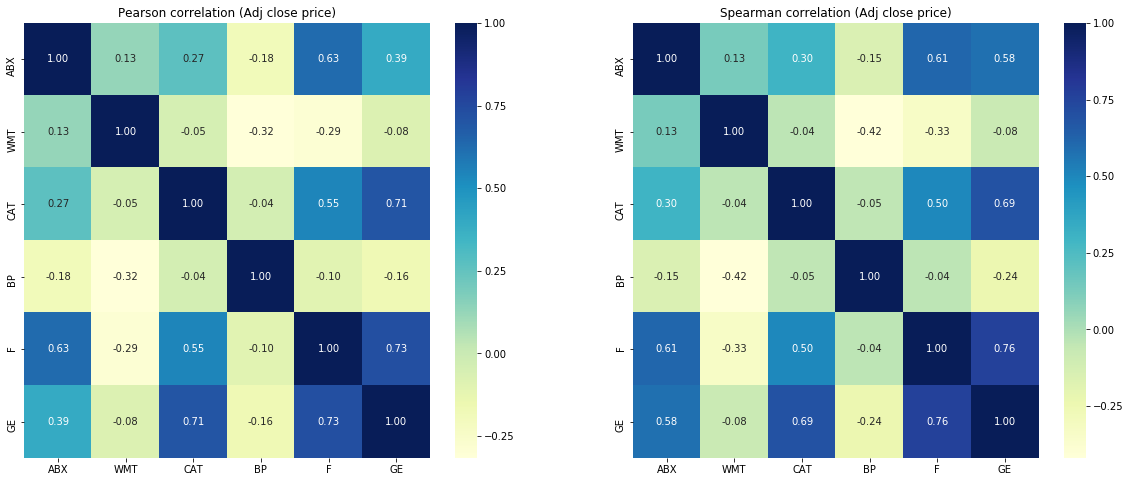

In [21]:
corr_plot(adj_close, asset_names, title='Adj close price')

In the figure right above, Pearson correlation for asset adjusted close price is demonstrated on the left, while Spearman correlation is on the right. We see that some of the prices tend to comoving while others moving in opposite directions.

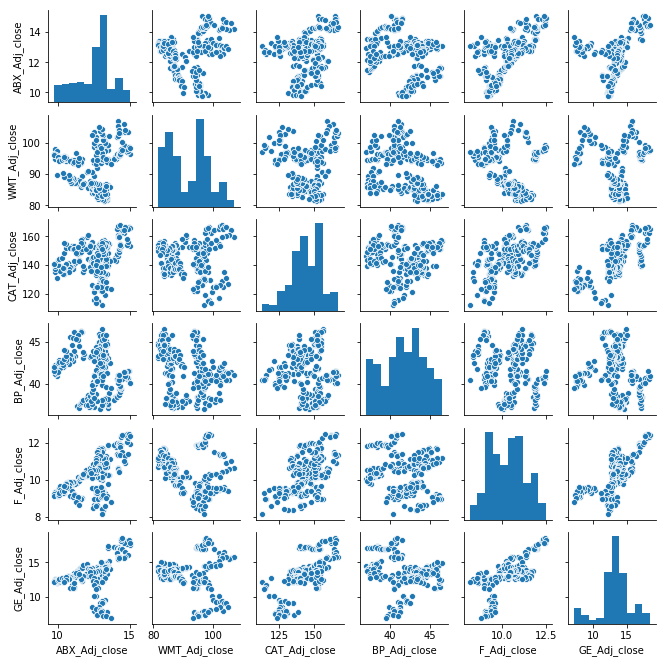

In [22]:
pairplot(adj_close, width=9, height=9)

The above is the scatter plot for adjusted close prices. This allows us to see general tendency of asset pairs.

According to the correlation analysis, the assets considered here tend to comoving. However, we should
also remember what time-interval is considered. Here we take into account 252 days interval corresponding to about 1 trading year. If some other time interval is of interest, then correlation coefficients for all of the assets change appropriately. It is not possible to know in advance whether the correlation between the assets will be higher, remain the same or lower with changing a time-period. But such an analysis demonstrates an estimation of their possible correlation values.

### 2.2.  A normal quantile-quantile plot and Comparison of their Kernel Density Estimation (KDE) to the closest parametric normal distribution

In this section, we discuss return and adj close price distributions of United Continental Holdings Inc. (UAL), BP p.l.c. (BP), American Water Works Company Inc. (AWK), Ford Motor Company (F), General Electric Company (GE) and Walmart Inc. (WMT). 

As previously, we introduce several auxiliary functions first.

In [23]:
def norm_function(x, mu, sigma):
    return (1/(sigma*np.sqrt(2*np.pi))) * np.exp(-(x-mu)**2 / (2*sigma**2))

In [24]:
def qqplot_returns(df, symbols, option='returns', size=(10,5), sharex=False, sharey=False, wspace=0.6, hspace=0.4):
    
    """
    
        Input:
              - df:
              - symbols:
              - option: returns or adj_close
              - size:
              - sharex:
              - sharey:
              - wspace:
              - hspace:
              
        
        Output:
              - illustration of a normal quantile-quantile plot of returns
    
    """
    nrows = len(symbols)
    if nrows != 1:
        fig, axes = plt.subplots(nrows=nrows, ncols=2, sharex=sharex, sharey=sharey, figsize=size)
        plt.subplots_adjust(wspace=wspace, hspace=hspace)
        for i in range(nrows):
            
            if option == 'returns':
                name = '%s' % symbols[i]
                name_return = '%s_returns' % symbols[i]
            elif option == 'adj_close':
                name = '%s' % symbols[i]
                name_return = '%s_Adj_close' % symbols[i]
                
            probplot = sm.ProbPlot(df[name_return], dist='norm')  
            fig = probplot.qqplot(line='q', ax=axes[i,0])
            axes[i,0].set_title('Normal Q-Q Plot (%s)' % name)

            sns.distplot(df[name_return], kde=True, hist=False, ax=axes[i,1], color='black')
            count, mean, std, min_, q1, mean, q3, max_ = df[name_return].describe()
            xx = np.linspace(min_, max_, 1000)
            axes[i,1].plot(xx, norm_function(xx, mean, std), '--', color='red')            
            axes[i,1].set_title(name)
            axes[i,1].set_xlabel('')
        plt.show()
    
    else:        
        if option == 'returns':
            name = '%s' % symbols[1]
            name_return = '%s_returns' % symbols[1]
        elif option == 'adj_close':
            name = '%s' % symbols[1]
            name_return = '%s_Adj_close' % symbols[1]
        
        nrows = 1
        fig, axes = plt.subplots(nrows=nrows, ncols=2, sharex=sharex, sharey=sharey, figsize=size)
        plt.subplots_adjust(wspace=wspace, hspace=hspace)
        name = '%s' % symbols[0]
        name_return = '%s_returns' % symbols[0]

        probplot = sm.ProbPlot(df[name_return], dist='norm')  
        fig = probplot.qqplot(line='q', ax=axes[0])
        axes[0].set_title('Normal Q-Q Plot (%s)' % name)

        sns.distplot(df[name_return], kde=True, hist=False, ax=axes[1], color='black')
        count, mean, std, min_, q1, mean, q3, max_ = df[name_return].describe()
        xx = np.linspace(min_, max_, 1000)
        axes[1].plot(xx, norm_function(xx, mean, std), '--', color='red')            
        axes[1].set_title(name)
        axes[1].set_xlabel('')
        plt.show()

---

#### 2.2.1 Asset Prices 

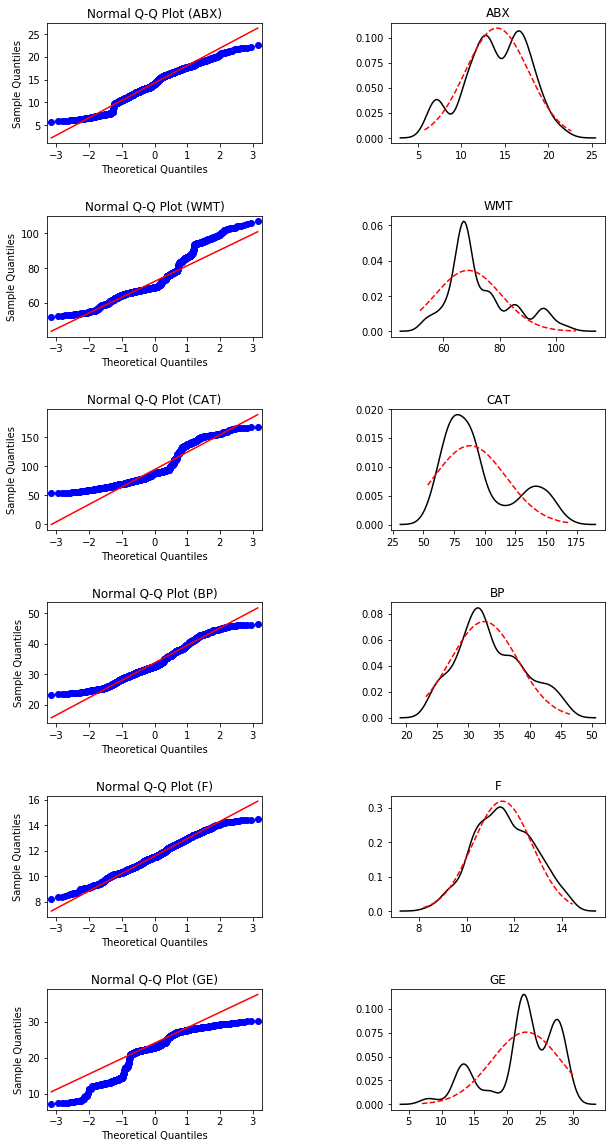

In [25]:
qqplot_returns(adj_close, asset_names, option='adj_close',
               size=(10,20), sharex=False, sharey=False, wspace=0.6, hspace=0.6)

On the left-hand side the normal quantile-quantile plots are shown, while on the right-hand side kernel density estimate of returns and their closest normal distribution are illustrated. Red lines correspond to normal distribution.

We see that some of adjusted close prices have bi-modal distributions while some others have even more complex structure which does not appear to be normal even close.

#### 2.2.1 Asset Returns 

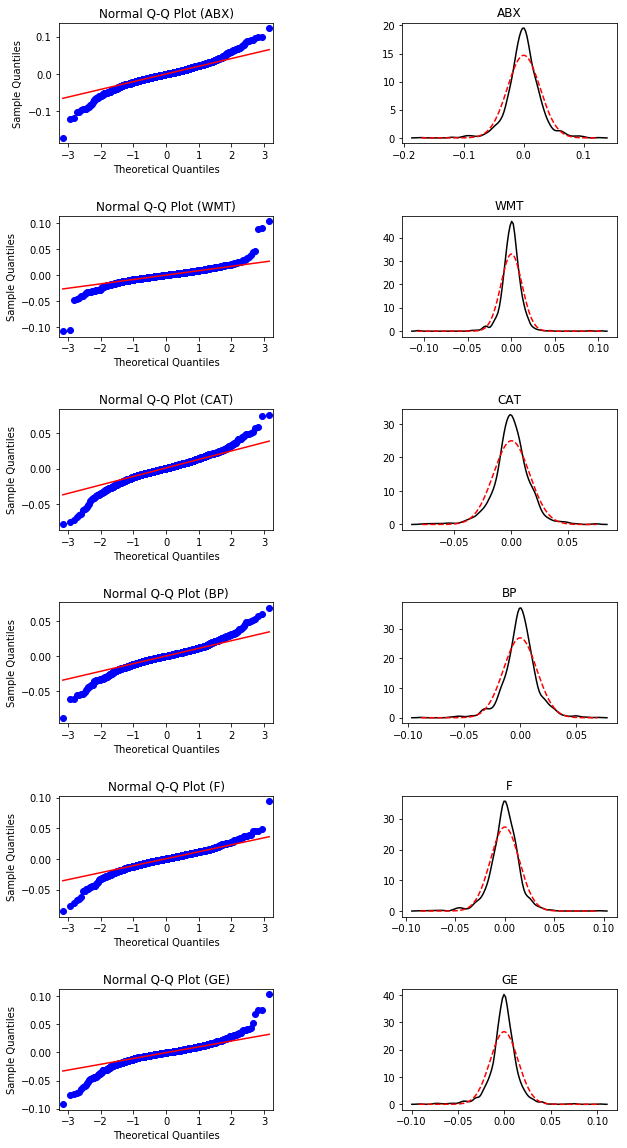

In [26]:
qqplot_returns(returns, asset_names, option='returns',
               size=(10,20), sharex=False, sharey=False, wspace=0.6, hspace=0.6)

Red lines correspond to normal distribution. Note that the distribution is not normal as demonstrated by both kinds of plots demonstrating fatter tails and higher kurtosis. However, their structure is closer to the normal distribution than that of adjusted close price.

On this stage of the work we may colcude that fat tails will become a problem for our ARIMA or ARMA modelling since it may be that we will not encompass all the time-series information due to that. Let's keep this notion in mind and move on.

### 2.3.  Skewness, Kurtosis, Max value, Min value, Mean and Variance

Now let's gather more statistics about target values. Precisely speaking, their Skewness, Kurtosis, Max returns, Max loss, Mean and Variances.

In [27]:
def stats(df, symbols):
    """
    
        Input: 
            - symbols: a list of asset symbols
            
        Output:
            - a dataframe containing information such as Skewness, Kurtosis, Max value,
              Min value, Mean and Variance of the df
        
    """
    
    stat = pd.DataFrame(index=asset_names, 
                                columns=['Skewness','Kurtosis','Max value',
                                         'Min value','Mean','Variance'])
    
    stat['Skewness'] = skew(df, axis=0)
    stat['Kurtosis'] = kurtosis(df, axis=0)
    stat['Max value'] = df.agg('max').values
    stat['Min value'] = df.agg('min').values
    stat['Mean'] = df.agg('mean').values
    stat['Variance'] = df.agg('var').values

    return stat

In [28]:
stats(adj_close, asset_names)

Skewness  Kurtosis   Max value  Min value       Mean    Variance
ABX -0.296287 -0.538592   22.630032   5.750702  14.059425   13.234067
WMT  0.825894 -0.011779  107.010101  51.773445  73.242156  133.737496
CAT  0.834336 -0.561894  167.927460  53.464493  95.752004  855.647013
BP   0.360279 -0.583571   46.459087  23.173573  33.660785   29.222048
F    0.039854 -0.512979   14.447714   8.180000  11.576889    1.569655
GE  -0.850812 -0.110201   30.092396   7.010000  22.347276   27.903293

In [29]:
stats(returns, asset_names)

Skewness   Kurtosis  Max value  Min value      Mean  Variance
ABX -0.231618   3.397397   0.123010  -0.170784 -0.000119  0.000739
WMT -0.152985  18.770065   0.103444  -0.107399  0.000234  0.000146
CAT -0.291100   3.134340   0.075671  -0.078606  0.000423  0.000255
BP  -0.203216   3.168546   0.069155  -0.088332  0.000115  0.000220
F   -0.555645   4.667572   0.094421  -0.085174 -0.000319  0.000213
GE  -0.331204   6.558640   0.102597  -0.091911 -0.000932  0.000225

### 2.4.  Box plot of Returns

Box plot will help us to get the precise information about outliers and how they fit in the whole picture.

In [30]:
def asset_box_plot(df, symbols, title=None, width=700, height=400, 
                   jitter=0.2, pointpos=-1.5, boxpoints = 'suspectedoutliers'):
    """
    
        Input: 
              - df: a dataframe which columns will be plotted, 
              - symbols: a list of symbols in the order the same as that in dataframe.
              - title:
              - width: 
              - height: 
              - jitter: 
              - pointpos: 
              
        Output: 
              - Box plot illustrated by plotly library
    
    """
    
    data=[]
    for i in range(len(symbols)):
        trace = go.Box(y = df.iloc[:,i],
                       name = symbols[i],
                       jitter=jitter,
                       pointpos=pointpos,
                       boxpoints = boxpoints)

        data.append(trace)
        
        
    layout = go.Layout(title = title,
                       autosize=False,
                       width=width,
                       height=height)

    fig = go.Figure(data=data,layout=layout)

    iplot(fig)

### 2.4.1 Asset Price

In [31]:
asset_box_plot(adj_close, asset_names, title='Adj close price', boxpoints = 'suspectedoutliers')

### 2.4.2 Asset Returns

In [32]:
asset_box_plot(returns, asset_names, title='Returns')

### 2.5.  Time-series plots

In [33]:
# A function for plotting stock price history of all assets
def plot_prices(df, symbols, width=500, height=300):
    """
    
        Input: First:  list with symbols of traded stocks
               Second: dataframe containing only adjusted close price columns
    
        Output: asset prices plotting with plotly
    
    """
    traces = []
    for asset in symbols:
        trace = go.Scatter(
                    x=df.index,
                    y=df['%s_Adj_close' % asset],
                    name = '%s price' % asset)
        traces.append(trace)
        
    layout = go.Layout(title='Adj close price history', 
                       autosize=False,
                       width=width,
                       height=height)
#    layout = {'title': 'Stocks Price History'}
    fig = go.Figure(data=traces, layout=layout) 
    
    return iplot(fig, show_link=False)

#### 2.5.1  Asset Prices 

In [34]:
plot_prices(adj_close, asset_names, height=600, width=800)

#### 2.5.2  Asset Returns 

In [35]:
# A function for plotting history of log returns for all assets
def plot_returns(df, symbols, width=500, height=300):
    """
    
        Input: First:  list with symbols of traded stocks
               Second: iterator with dataframes of traded stocks
    
        Output: asset log returns plotting with plotly
    
    """
    traces = []
    for asset in symbols:
        trace = go.Scatter(
                    x=df.index,
                    y=df['%s_returns' % asset],
                    name = '%s returns' % asset,
                    opacity=0.8)
        traces.append(trace)
        
    layout = go.Layout(title='Returns history',
              autosize=False,
              width=width,
              height=height)
    fig = go.Figure(data=traces, layout=layout) 
    
    return iplot(fig, show_link=False)

In [36]:
plot_returns(returns, asset_names)

It might be useful to see all the return values separately.

In [37]:
# A function for plotting history of log returns for all assets
def plot_returns_indiv(df, symbols, width=800, height=600):
    """
        
        Input: First:  list with symbols of traded stocks
               Second: iterator with dataframes of traded stocks
    
        Output: asset log returns plotting individually with plotly
    
    """
    traces = []
    count = 0
    for asset in symbols:
        trace = go.Scatter(
                    x=df.index,
                    y=df['%s_returns' % asset],
                    name = '%s returns' % asset,
                    opacity=0.8)
        traces.append(trace)
        count += 1
        
    fig = tools.make_subplots(rows=int(len(symbols)/2+0.5), cols=2, shared_yaxes=True)

    i = 0
    while i < count:
        for ncol in [1,2]:
            for nrow in range(1, int(len(symbols)/2+1.5)):
                fig.append_trace(traces[i], nrow, ncol)
                i += 1
        
    fig['layout'].update(width=width, height=height, title='Returns History')
 
    return iplot(fig, show_link=False)

In [38]:
plot_returns_indiv(returns, asset_names);

This is the format of your plot grid:
[ (1,1) x1,y1 ]  [ (1,2) x2,y1 ]
[ (2,1) x3,y2 ]  [ (2,2) x4,y2 ]
[ (3,1) x5,y3 ]  [ (3,2) x6,y3 ]



From the figures of the return time-series one can see that 

1. The assets do not have long-term deviations from the mean and are mainly oscillating over some constant values that is almost zero. This is a property of stationary process.
2. There are periods of high volatility followed by periods of relatively tranquility (volatility clustering).
3. One can also notice that volatility clustering does not indicate a lack of stationarity but rather can be viewed as a type of dependence in the conditional variance of each series.

Next we are going to determine whether price and return time-series are stationary by finding Autocorrelation Function (ACF) and Partial Autocorrelation Function (PACF).

### 2.6.  Autocorrelation Function (ACF) and Partial Autocorrelation Function (PACF)

When a time series is observed, a natural question is whether it appears to be stationary. In this section, we plot ACF and PACF in order to check the series on the presence of stationarity. We also perform Augmented Dickey-Fuller test as well as Kwiatkowski-Phillips-Schmidt-Shin test. The former tests null hypothesis that timeseries is not stationary against an alternative hypothesis that the time-series is stationary, while the latter test is designed to test null stationarity against an alternative of non-stationarity.

In [39]:
def stationary_analysis(df, symbols, lags, option='price', figsize=(10,20), wspace=0.3, hspace=0.5):
    """
        Plot time series, its Autocorrelation Function (ACF) and Partial Autocorrelation function (PACF)
        
        Input: 
              - df: Dataframe where columns represent either price or return values. 
              - symbols:  Whether stationary analysis is perfored for price or return is 
              - lags: regulated by option parameter. The latter should be either 
              - option: 'price' or 'return'
              - figsize:
              - wspace: 
              - hspace:
              
        Output: 
              - Illustration of Autocorrelation function in the right column, 
                and Partial autocorrelation function in the left
    """
    
    nrows = df.shape[1]
    fig, axes = plt.subplots(nrows=nrows, ncols=2, figsize=figsize)
    plt.subplots_adjust(wspace=0.3, hspace=0.5)
    row = 0
    for asset in symbols:
        if option == 'price':
            smt.graphics.plot_acf(df['%s_Adj_close' % asset], lags=lags, ax=axes[row,0])
            smt.graphics.plot_pacf(df['%s_Adj_close' % asset], lags=lags, ax=axes[row,1])
            axes[row,0].set_title('%s Adj close (ACF)' % asset)
            axes[row,1].set_title('%s Adj close (PACF)' % asset)
            row += 1
        elif option == 'return':
            smt.graphics.plot_acf(df['%s_returns' % asset], lags=lags, ax=axes[row,0])
            smt.graphics.plot_pacf(df['%s_returns' % asset], lags=lags, ax=axes[row,1])
            axes[row,0].set_title('%s returns (ACF)' % asset)
            axes[row,1].set_title('%s returns (PACF)' % asset)
            row += 1     
    
    return plt.show()

In [40]:
def adf_kpss(df, symbols, option='price'):
    
    """
        Input:
            - df: a dataframe containing only either of prices or returns
            - symbols: list of asset symbols to analyze
            - option: either price or returns in accordance with df
    
        Output:
            - a dataframe constaining Augmented Dickey-Fuller (ADF) and Kwiatkowski–Phillips–Schmidt–Shin (KPSS) 
              test results of asset prices or returns 
    
    """
    adf_kpss = pd.DataFrame(index=asset_names, columns=['ADF','KPSS'])
    
    if option == 'price':
        adf_price = []
        kpss_price = []
        for i in range(len(symbols)):
            adf_price.append(ts.adfuller(adj_close.iloc[:,i])[1])
            kpss_price.append(kpss(adj_close.iloc[:,i])[1])
        adf_kpss['ADF'] = np.array(adf_price)
        adf_kpss['KPSS'] = np.array(kpss_price)
    
    elif option == 'returns':
        adf_returns = []
        kpss_returns = []
        for i in range(len(asset_names)):
            adf_returns.append(ts.adfuller(returns.iloc[:,i])[1])
            kpss_returns.append(kpss(returns.iloc[:,i])[1])
        adf_kpss['ADF'] = np.array(adf_returns)
        adf_kpss['KPSS'] = np.array(kpss_returns)
        
    return adf_kpss

---

#### 2.6.1  Asset Prices 

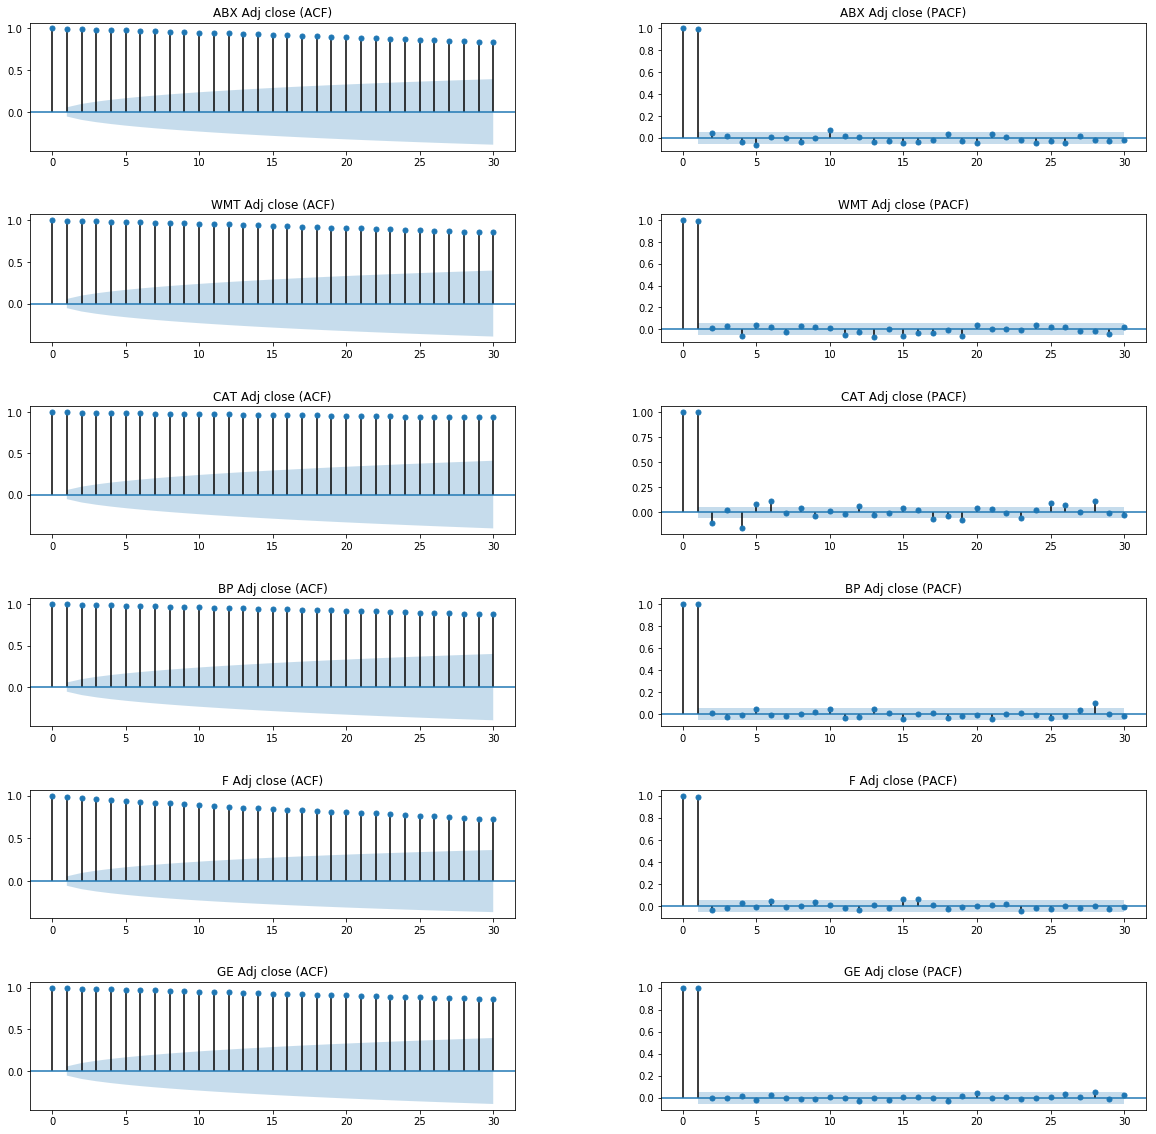

In [41]:
stationary_analysis(adj_close, asset_names, option='price', lags=30, figsize=(20,20))

Autocorrelation Function (ACF) and Partial Autocorrelation Function (PACF) for six-price time-series (Barrick Gold Corporation (ABX), Walmart Inc. (WMT), Caterpillar Inc (CAT), BP p.l.c. (BP), Ford Motor Company (F) and General Electric Company (GE)). One can see that each ACF shows a very slow (barely noticeable), linear decay pattern which is typical of a nonstationary time series. Besides, PACF has one significant spike at lag 1 (lag 0 is not accounted for) meaning that (almost) all the higher-order autocorrelations are effectively explained by the lag 1 autocorrelation. Such ACF and PACF are typical for non-stationary time-series. There are also some test-statistic to either support or reject our assumptions.

To prove our initial guessing about the behavior of price time-series, we perform Augmented Dickey-Fuller
(ADF) test and Kwiatkowski–Phillips–Schmidt–Shin (KPSS) test.

In [42]:
adf_kpss_price = pd.DataFrame(index=asset_names, columns=['ADF','KPSS'])

adf_price = []
kpss_price = []
for i in range(len(asset_names)):
    adf_price.append(ts.adfuller(adj_close.iloc[:,i])[1])
    kpss_price.append(kpss(adj_close.iloc[:,i])[1])

/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/stattools.py:1276: InterpolationWarning:

p-value is smaller than the indicated p-value

/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/stattools.py:1276: InterpolationWarning:

p-value is smaller than the indicated p-value

/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/stattools.py:1276: InterpolationWarning:

p-value is smaller than the indicated p-value

/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/stattools.py:1276: InterpolationWarning:

p-value is smaller than the indicated p-value

/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/stattools.py:1276: InterpolationWarning:

p-value is smaller than the indicated p-value



In [43]:
adf_kpss_price['ADF'] = np.array(adf_price)
adf_kpss_price['KPSS'] = np.array(kpss_price)

In [44]:
adf_kpss_price

ADF     KPSS
ABX  0.419865  0.05578
WMT  0.834157  0.01000
CAT  0.780077  0.01000
BP   0.599295  0.01000
F    0.235689  0.01000
GE   0.995173  0.01000

This table contains p-values information on whether or not to reject the null hypothesis. Since ADF tests gives p-values larget than 0.05, we do not have enough information to reject the null hypothesis stating that time-series is not stationary at 95% confidence level. Besides, KPSS p-values shows that we reject the null hypothesis that time series is stationary at 95% confidence level, but ABX. The latter is probably a deviation due to insufficient data. In general, combination of ADF and KPSS test results proves that time-series of the adjusted close prices are not stationary.

#### 2.6.2  Asset Returns 

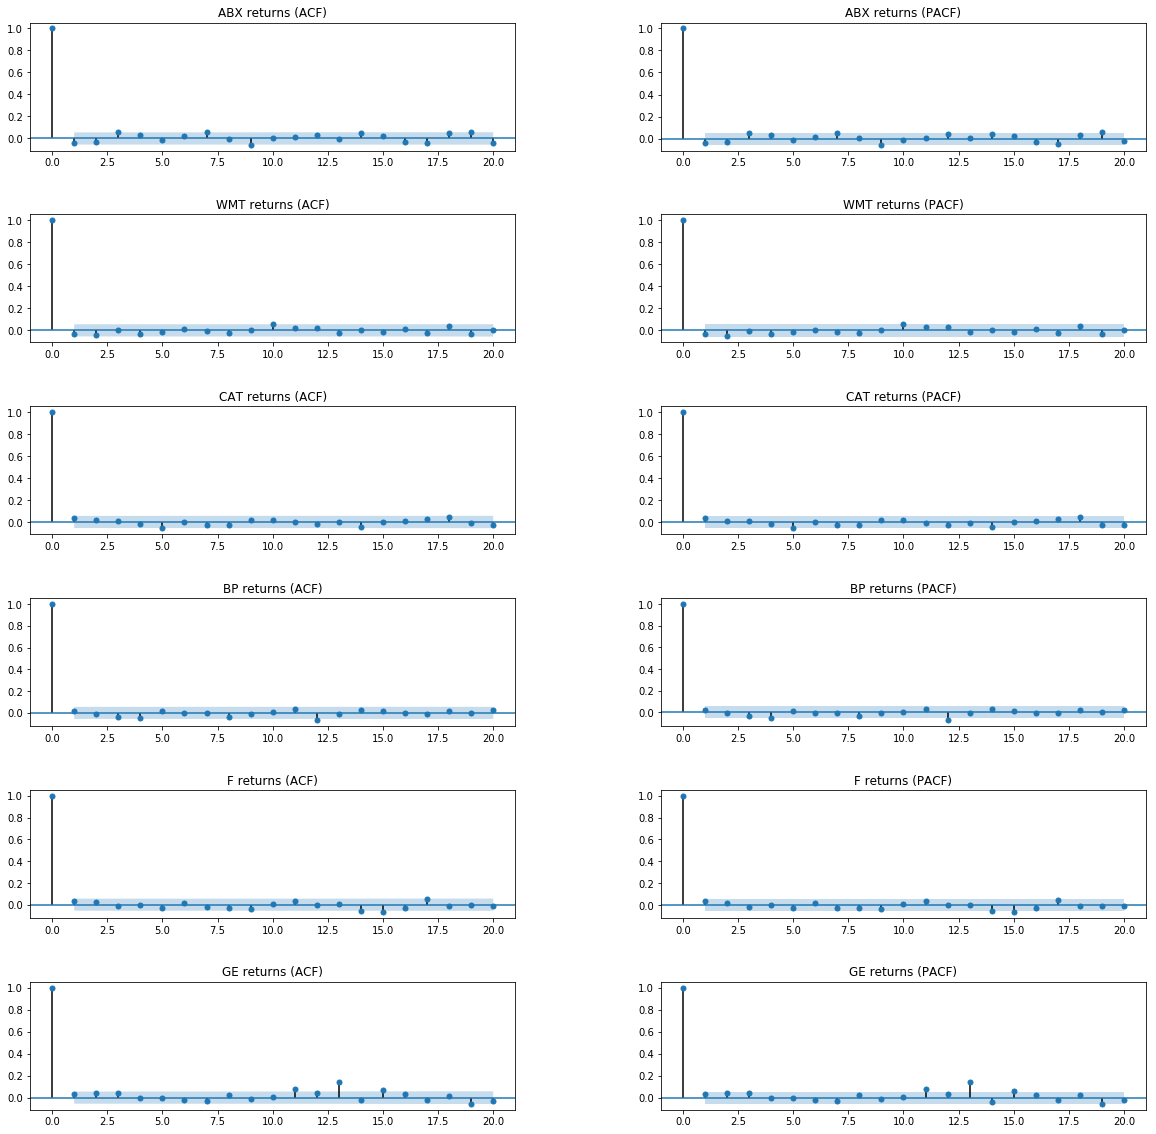

In [45]:
stationary_analysis(returns, asset_names, option='return', lags=20, figsize=(20,20))

ACF and PACF demonstrate that time-series of returns should be stationary. Let's support this by performing ADF and KPSS tests.

In [46]:
adf_kpss_returns = pd.DataFrame(index=asset_names, columns=['ADF','KPSS'])

adf_returns = []
kpss_returns = []
for i in range(len(asset_names)):
    adf_returns.append(ts.adfuller(returns.iloc[:,i])[1])
    kpss_returns.append(kpss(returns.iloc[:,i])[1])

/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/stattools.py:1278: InterpolationWarning:

p-value is greater than the indicated p-value

/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/stattools.py:1278: InterpolationWarning:

p-value is greater than the indicated p-value

/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/stattools.py:1278: InterpolationWarning:

p-value is greater than the indicated p-value

/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/stattools.py:1278: InterpolationWarning:

p-value is greater than the indicated p-value

/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/stattools.py:1278: InterpolationWarning:

p-value is greater than the indicated p-value

/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/stattools.py:1276: InterpolationWarning:

p-value is smaller than the indicated p-value



In [47]:
adf_kpss_returns['ADF'] = np.array(adf_returns)
adf_kpss_returns['KPSS'] = np.array(kpss_returns)

In [48]:
adf_kpss_returns

ADF  KPSS
ABX  0.000000e+00  0.10
WMT  0.000000e+00  0.10
CAT  0.000000e+00  0.10
BP   0.000000e+00  0.10
F    0.000000e+00  0.10
GE   9.505554e-10  0.01

From the table we see that for all the assets except GE, ADF null-hypothesis stating that time-series is not stationary may be rejected with 95% confidence level, while p-values of KPSS test indicate that there is not enough information to reject its null-hypothesis that time series is stationary at 95% confidence level. Then we may conclude that time-series of returns is stationary meaning that we can use ARMA for ABX, WMT, CAT, BP and F assets. However, we should be careful with GE. To be on the safe side, we include $d$ parameter while doing ARIMA grid search for GE.

### 3. Metrics and Model selection

#### 3.1.  ARIMA Model and Box-Ljung test

Here we build ARIMA model for stationary time-series of asset returns following the steps:

1. Identify p and q values of ARIMA by using grid search incorporating **Akaike information criterion metrics**. 
2. Plot figures and investigate residuals distribution (whether they have white noise properties or not)
3. Apply Box-Ljung test to ARIMA residuals (null hypothesis is that residuals are white noise)
4. Make predictions by using ARIMA models

We use the material mentioned from:

1. https://mlcourse.ai/notebooks/blob/master/jupyter_english/topic09_time_series/topic9_part1_time_series_python.ipynb?flush_cache=true

2. http://www.blackarbs.com/blog/time-series-analysis-in-python-linear-models-to-garch/11/1/2016

In [63]:
# Defined the function to fit ARIMA(p, d, q) model
# pick best order and final model based on aic

def arima_model(df, symbol):

    """
    
        Input: 
    
        Output:
    
    """
    
    asset = df['%s_returns' % symbol]    
    best_aic = np.inf 
    best_order = None
    best_mdl = None

    pq_rng = range(6) # [0,1,2,3,4 5]  (for GE this was extended up to range(8))
    d_rng = range(1) # [0]  (for GE we used range(2))
    
    for p in pq_rng:
        for d in d_rng:
            for q in pq_rng:
                try:
                    tmp_mdl = smt.ARIMA(asset, order=(p,d,q)).fit(method='mle', trend='nc')
                    tmp_aic = tmp_mdl.aic
                    if tmp_aic < best_aic:
                        best_aic = tmp_aic
                        best_order = (p, d, q)
                        best_mdl = tmp_mdl
                except: continue


#    print(' {}: aic: {:6.5f} | order: {}'.format(symbol, best_aic, best_order))
    return best_aic, best_order, best_mdl

In [64]:
def tsplot(y, lags=None, figsize=(10, 8), style='bmh', name='asset'):
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
    with plt.style.context(style):    
        fig = plt.figure(figsize=figsize)
        #mpl.rcParams['font.family'] = 'Ubuntu Mono'
        layout = (3, 2)
        ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1, 0))
        pacf_ax = plt.subplot2grid(layout, (1, 1))
        qq_ax = plt.subplot2grid(layout, (2, 0))
        pp_ax = plt.subplot2grid(layout, (2, 1))
        
        y.plot(ax=ts_ax)
        ts_ax.set_title('Time Series Analysis Plots: %s' % name, fontsize=20)
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax, alpha=0.5)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax, alpha=0.5)
        sm.qqplot(y, line='s', ax=qq_ax)
        qq_ax.set_title('QQ Plot')        
        scs.probplot(y, sparams=(y.mean(), y.std()), plot=pp_ax)

        plt.tight_layout()

---

In [54]:
# run ARMA model for the asset returns
# save ARMA output as dictionaries
"""
aic_dict = {}
order_dict = {}
mdl_dict = {}
for symbol in asset_names:
aic_dict[symbol], order_dict[symbol], mdl_dict[symbol] = arima_model(returns, symbol)
"""

'\naic_dict = {}\norder_dict = {}\nmdl_dict = {}\nfor symbol in asset_names:\naic_dict[symbol], order_dict[symbol], mdl_dict[symbol] = arima_model(returns, symbol)\n'

To save time, we mention the results of the grid search for ARMA:

- ABX: ARMA(3,2)
- WMT: ARMA(0,2)
- CAT: ARMA(1,0)
- BP:  ARMA(5,4)
- F:   ARMA(5,5)
- GE:  ARIMA(6,1,7)

Grid search was based on Akaike Information Criterion. The formed is restricted in order to find parsimonious values, while the latter was used because returns time-series are stationary as was proved above.

In [52]:
order_dict = {}
mdl_dict = {}

In [53]:
order_dict['ABX'] = (3,0,2)
order_dict['WMT'] = (0, 0, 2)
order_dict['CAT'] = (1, 0, 0)
order_dict['BP'] = (5,0,4)
order_dict['F'] = (5, 0, 5)
order_dict['GE'] = (6, 1, 7)

In [55]:
mdl_dict['ABX'] = smt.ARIMA(returns.ABX_returns, order=(3,0,2)).fit(method='mle', trend='nc')
mdl_dict['WMT'] = smt.ARIMA(returns.WMT_returns, order=(0,0,2)).fit(method='mle', trend='nc')
mdl_dict['CAT'] = smt.ARIMA(returns.CAT_returns, order=(1,0,0)).fit(method='mle', trend='nc')
mdl_dict['BP'] = smt.ARIMA(returns.BP_returns, order=(5,0,4)).fit(method='mle', trend='nc')
mdl_dict['F'] = smt.ARIMA(returns.F_returns, order=(5,0,5)).fit(method='mle', trend='nc')
mdl_dict['GE'] = smt.ARIMA(returns.GE_returns, order=(6,1,7)).fit(method='mle', trend='nc')

/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning:

A date index has been provided,

In [55]:
#for symbol in asset_names:
#    print (mdl_dict[symbol].summary())
#    tsplot(mdl_dict[symbol].resid, lags=30)

                              ARMA Model Results                              
Dep. Variable:            ABX_returns   No. Observations:                 1257
Model:                     ARMA(3, 2)   Log Likelihood                2761.861
Method:                           mle   S.D. of innovations              0.027
Date:                Mon, 17 Dec 2018   AIC                          -5511.723
Time:                        19:41:25   BIC                          -5480.904
Sample:                             0   HQIC                         -5500.140
                                                                              
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
ar.L1.ABX_returns    -0.4340      0.028    -15.314      0.000      -0.490      -0.378
ar.L2.ABX_returns    -1.0155      0.011    -92.299      0.000      -1.037      -0.994
ar.L3.ABX_returns    -0.

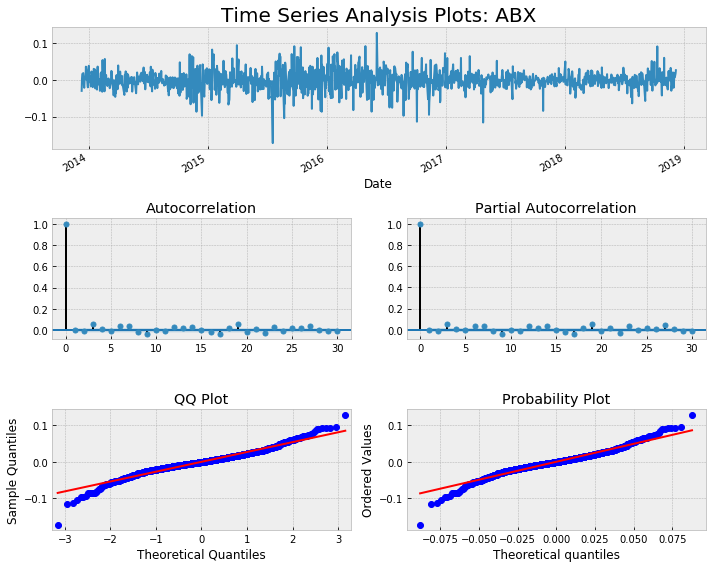

In [65]:
print (mdl_dict['ABX'].summary())
tsplot(mdl_dict['ABX'].resid, lags=30, name='ABX')

                              ARMA Model Results                              
Dep. Variable:            WMT_returns   No. Observations:                 1257
Model:                     ARMA(0, 2)   Log Likelihood                3770.172
Method:                           mle   S.D. of innovations              0.012
Date:                Mon, 17 Dec 2018   AIC                          -7534.345
Time:                        19:41:30   BIC                          -7518.935
Sample:                             0   HQIC                         -7528.553
                                                                              
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
ma.L1.WMT_returns    -0.0371      0.028     -1.314      0.189      -0.092       0.018
ma.L2.WMT_returns    -0.0479      0.029     -1.648      0.100      -0.105       0.009
                        

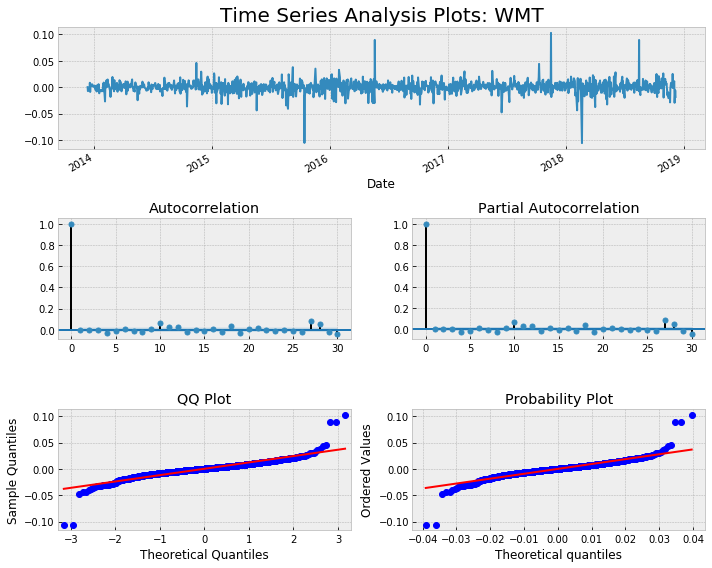

In [66]:
print (mdl_dict['WMT'].summary())
tsplot(mdl_dict['WMT'].resid, lags=30, name='WMT')

                              ARMA Model Results                              
Dep. Variable:            CAT_returns   No. Observations:                 1257
Model:                     ARMA(1, 0)   Log Likelihood                3418.412
Method:                           mle   S.D. of innovations              0.016
Date:                Mon, 17 Dec 2018   AIC                          -6832.824
Time:                        19:41:36   BIC                          -6822.551
Sample:                             0   HQIC                         -6828.963
                                                                              
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
ar.L1.CAT_returns     0.0381      0.028      1.348      0.178      -0.017       0.093
                                    Roots                                    
                  Real          

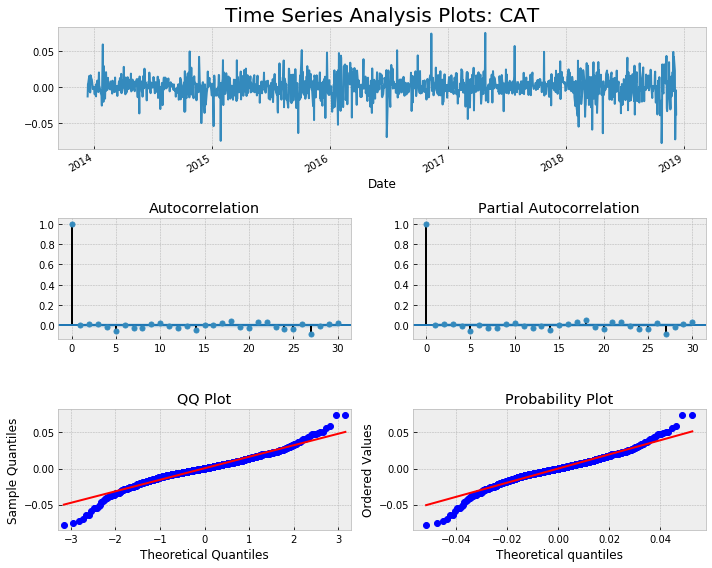

In [67]:
print (mdl_dict['CAT'].summary())
tsplot(mdl_dict['CAT'].resid, lags=30, name='CAT')

                              ARMA Model Results                              
Dep. Variable:             BP_returns   No. Observations:                 1257
Model:                     ARMA(5, 4)   Log Likelihood                3521.717
Method:                           mle   S.D. of innovations              0.015
Date:                Mon, 17 Dec 2018   AIC                          -7023.434
Time:                        19:41:40   BIC                          -6972.070
Sample:                             0   HQIC                         -7004.130
                                                                              
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
ar.L1.BP_returns     0.4187      0.126      3.333      0.001       0.173       0.665
ar.L2.BP_returns    -0.0160      0.085     -0.188      0.851      -0.183       0.151
ar.L3.BP_returns    -0.5015 

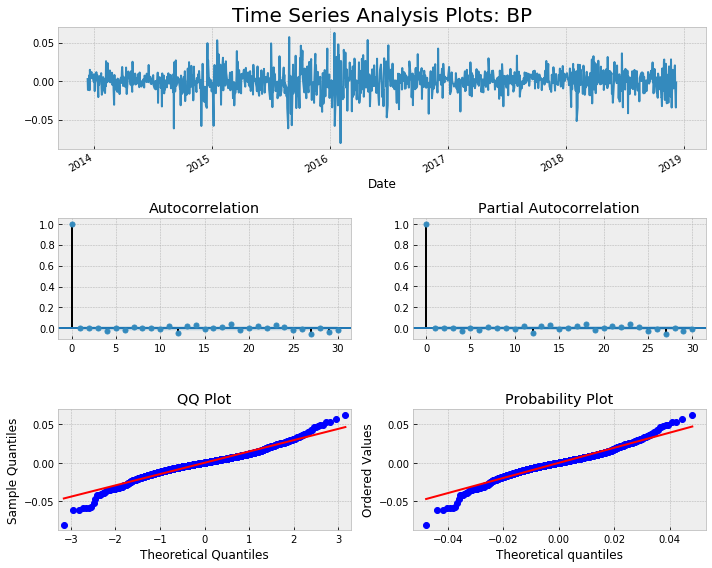

In [68]:
print (mdl_dict['BP'].summary())
tsplot(mdl_dict['BP'].resid, lags=30, name='BP')

                              ARMA Model Results                              
Dep. Variable:              F_returns   No. Observations:                 1257
Model:                     ARMA(5, 5)   Log Likelihood                3544.749
Method:                           mle   S.D. of innovations              0.014
Date:                Mon, 17 Dec 2018   AIC                          -7067.497
Time:                        19:41:43   BIC                          -7010.996
Sample:                             0   HQIC                         -7046.262
                                                                              
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
ar.L1.F_returns    -0.1884      0.263     -0.716      0.474      -0.704       0.328
ar.L2.F_returns     0.1297      0.135      0.958      0.338      -0.136       0.395
ar.L3.F_returns    -0.2296      

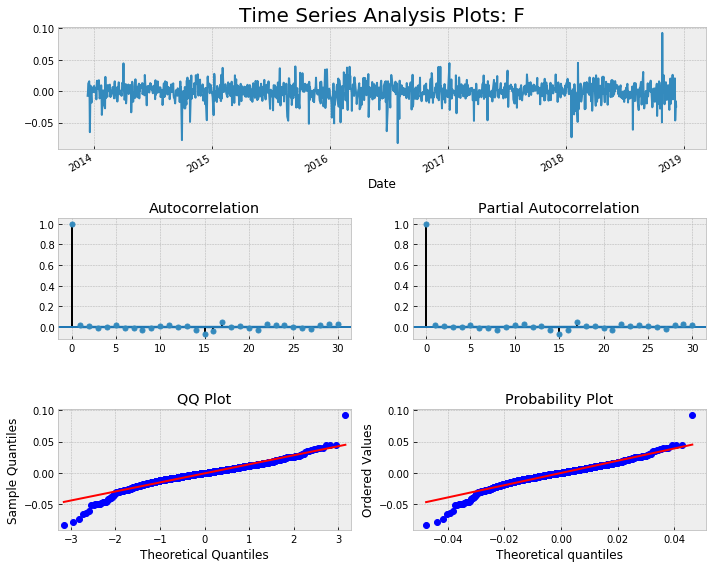

In [69]:
print (mdl_dict['F'].summary())
tsplot(mdl_dict['F'].resid, lags=30, name='F')

                             ARIMA Model Results                              
Dep. Variable:           D.GE_returns   No. Observations:                 1256
Model:                 ARIMA(6, 1, 7)   Log Likelihood                3518.804
Method:                           mle   S.D. of innovations              0.015
Date:                Mon, 17 Dec 2018   AIC                          -7009.608
Time:                        19:41:50   BIC                          -6937.708
Sample:                             1   HQIC                         -6982.585
                                                                              
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
ar.L1.D.GE_returns    -1.6398      0.101    -16.178      0.000      -1.838      -1.441
ar.L2.D.GE_returns     0.4520      0.069      6.553      0.000       0.317       0.587
ar.L3.D.GE_returns  

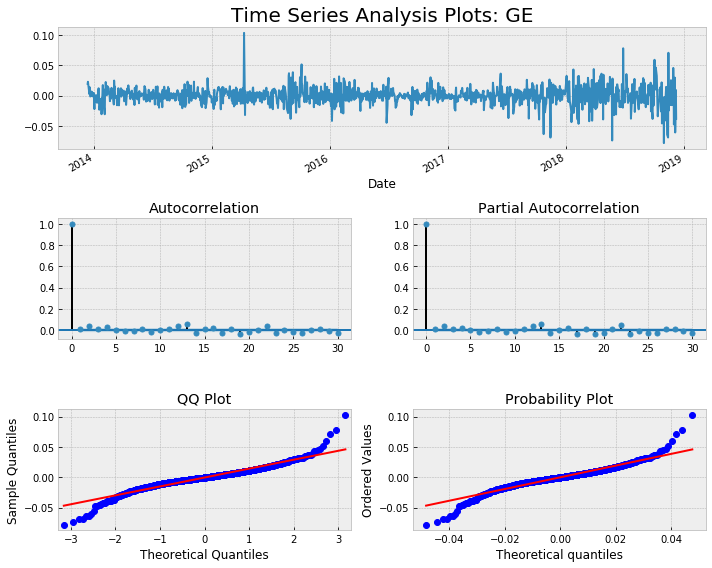

In [70]:
print (mdl_dict['GE'].summary())
tsplot(mdl_dict['GE'].resid, lags=30, name='GE')

From these figures one can see that there is almost none autocorrelation in the residuals. This should be checked by Ljung_box test

** Ljung-Box test**

In [71]:
ljung_box = {}
for symbol in asset_names:
    ljung_box[symbol] = acorr_ljungbox(mdl_dict['GE'].resid, lags=15)[1]

In [72]:
ljung_box

{'ABX': array([0.62736445, 0.40607297, 0.5614321 , 0.56224972, 0.70355706,
        0.7929005 , 0.87000296, 0.91260019, 0.9358614 , 0.96302923,
        0.97585494, 0.91505361, 0.71306041, 0.72153699, 0.78040789]),
 'BP': array([0.62736445, 0.40607297, 0.5614321 , 0.56224972, 0.70355706,
        0.7929005 , 0.87000296, 0.91260019, 0.9358614 , 0.96302923,
        0.97585494, 0.91505361, 0.71306041, 0.72153699, 0.78040789]),
 'CAT': array([0.62736445, 0.40607297, 0.5614321 , 0.56224972, 0.70355706,
        0.7929005 , 0.87000296, 0.91260019, 0.9358614 , 0.96302923,
        0.97585494, 0.91505361, 0.71306041, 0.72153699, 0.78040789]),
 'F': array([0.62736445, 0.40607297, 0.5614321 , 0.56224972, 0.70355706,
        0.7929005 , 0.87000296, 0.91260019, 0.9358614 , 0.96302923,
        0.97585494, 0.91505361, 0.71306041, 0.72153699, 0.78040789]),
 'GE': array([0.62736445, 0.40607297, 0.5614321 , 0.56224972, 0.70355706,
        0.7929005 , 0.87000296, 0.91260019, 0.9358614 , 0.96302923,
        0

We cannot reject the null hypothesis that the residuals are white noise at 95% confidence level.

** ARMA predictions**

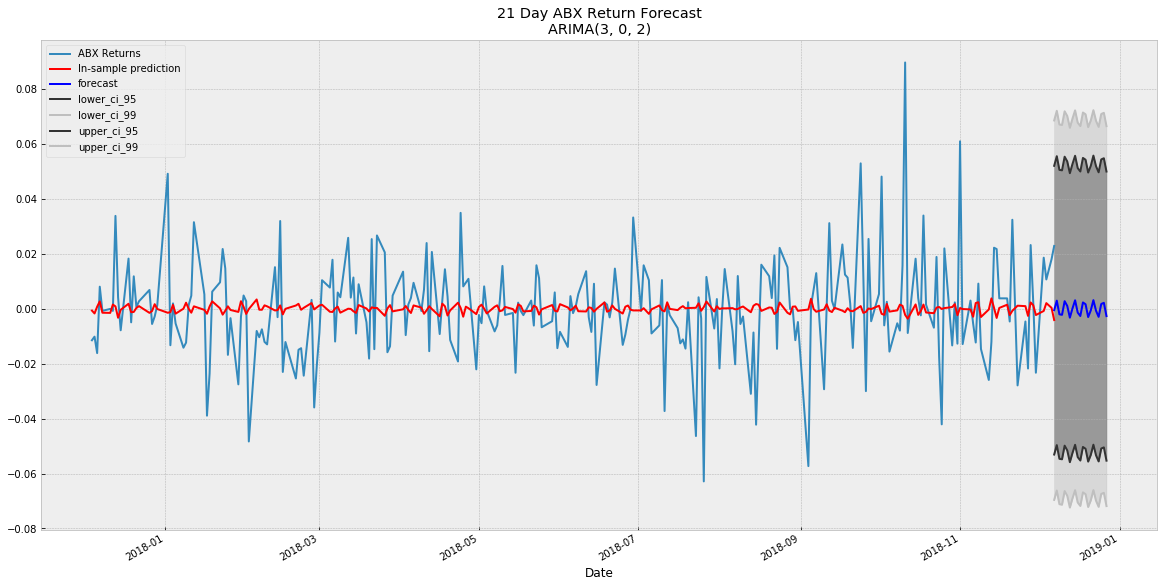

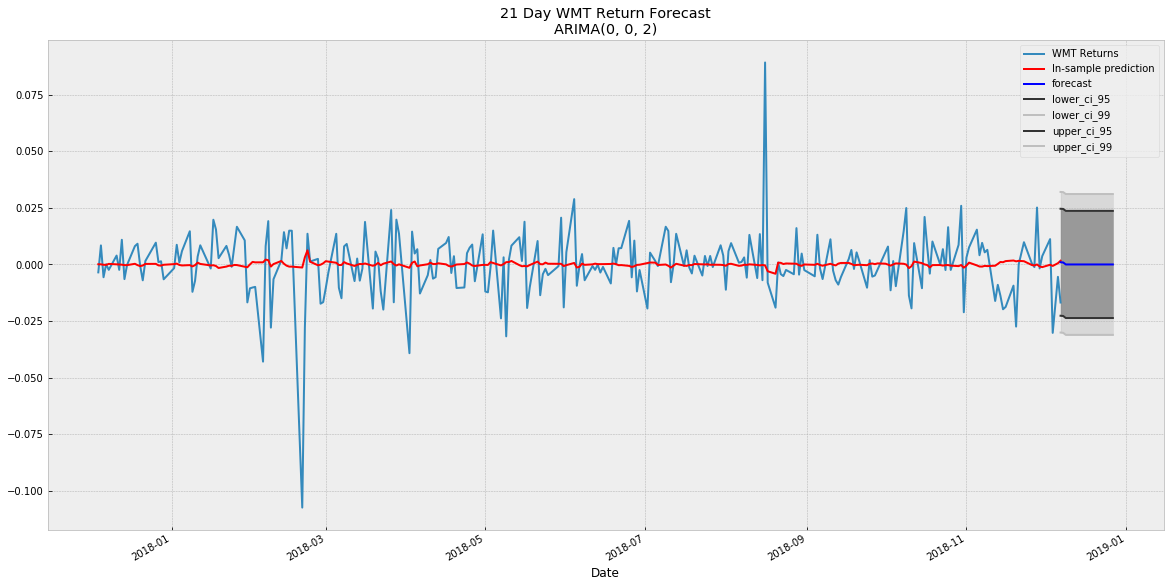

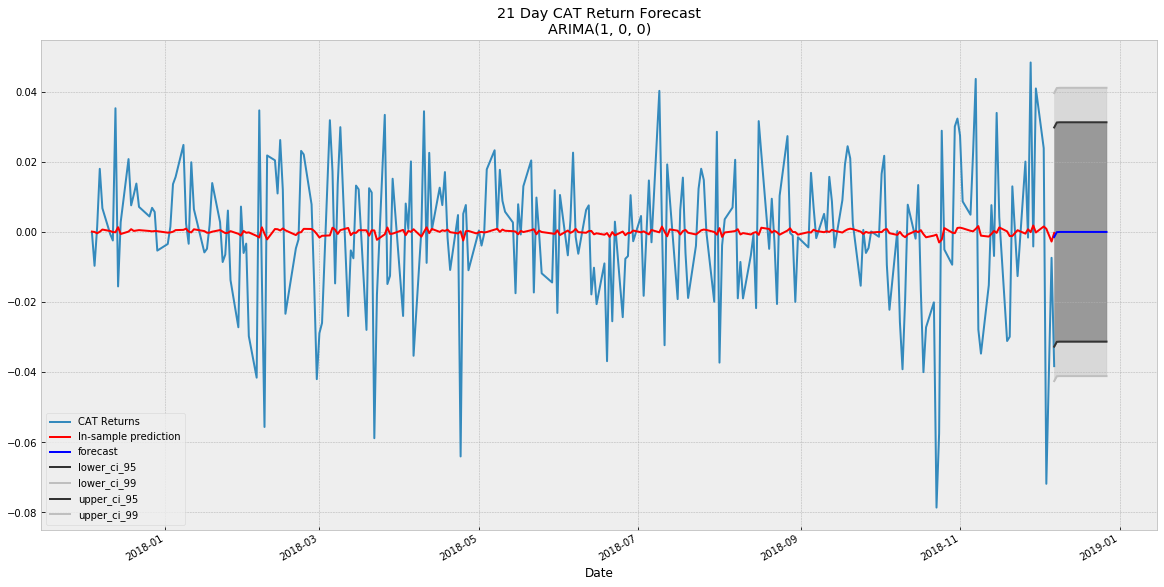

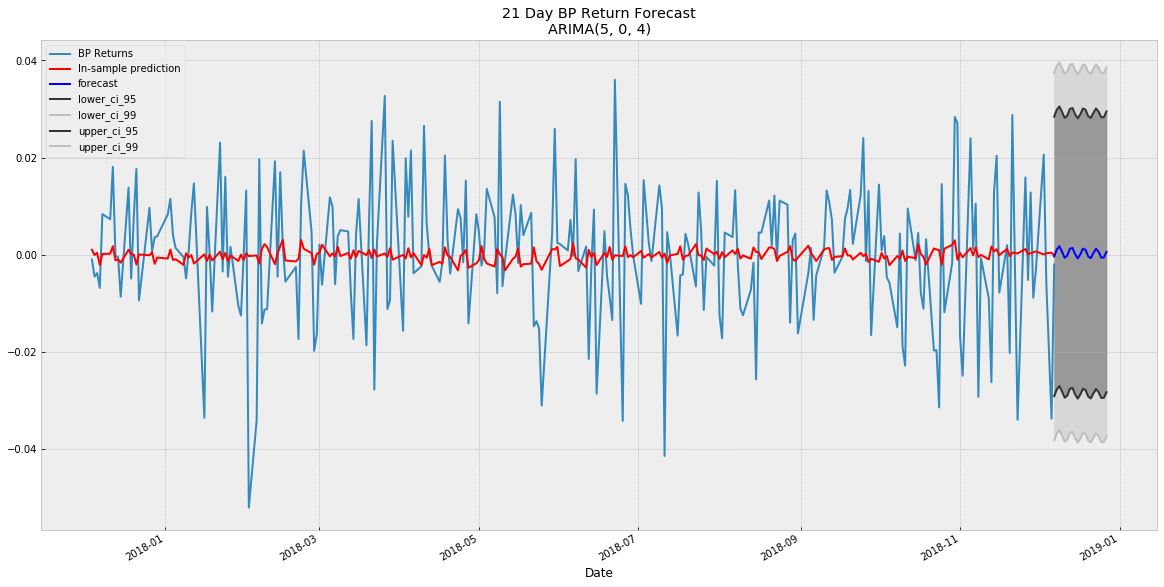

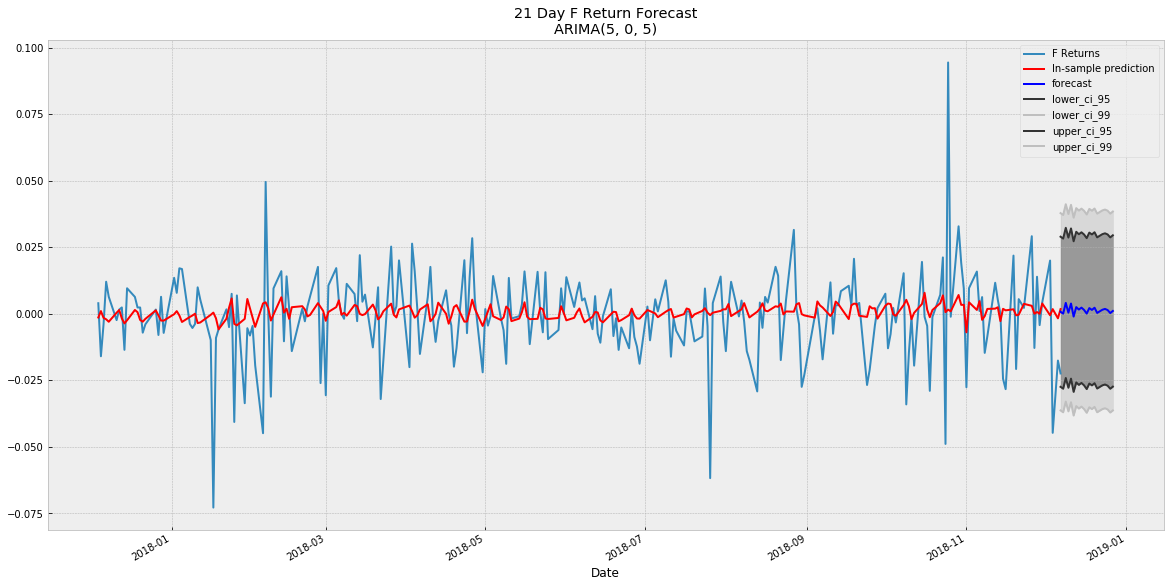

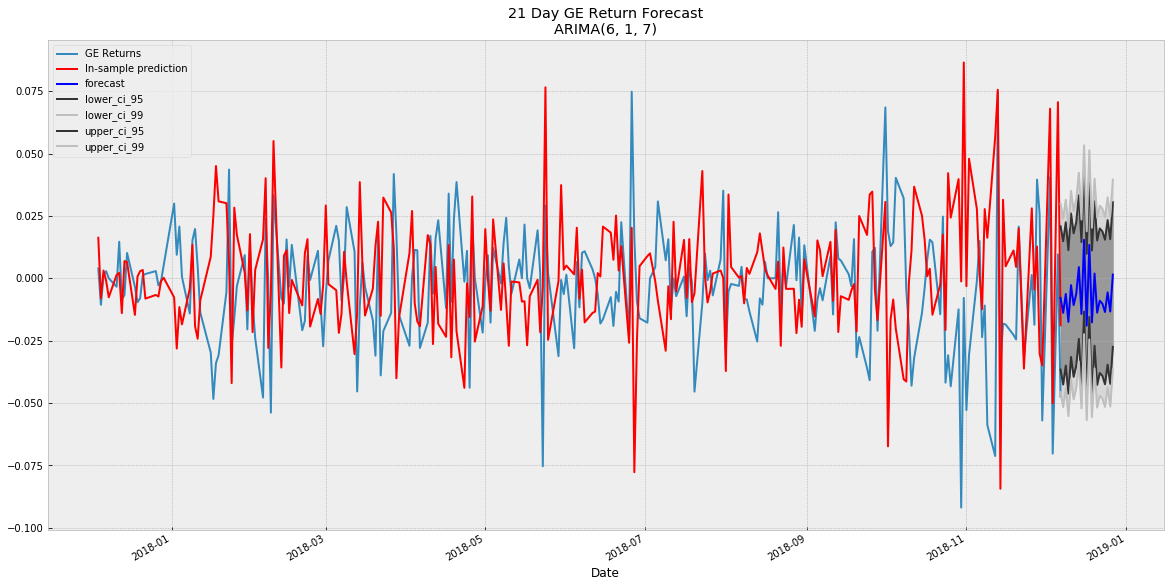

In [73]:
# Plot 21 day forecast
n_steps = 21
holdout_signal = {}
for symbol in asset_names:
    plt.style.use('bmh')
    fig = plt.figure(figsize=(20,10))
    ax = plt.gca()

    ts = returns['%s_returns' % symbol].iloc[-255:].copy()
    ts.plot(ax=ax, label='%s Returns' % symbol)
    pred = mdl_dict[symbol].predict()[-255:]
    pred.plot(ax=ax, style='r-', label='In-sample prediction')
    
    holdout_signal[symbol] = np.sign(pred.values)

    styles = ['b-', '0.2', '0.75', '0.2', '0.75']
    f, err95, ci95 = mdl_dict[symbol].forecast(steps=n_steps) # 95% CI
    _, err99, ci99 = mdl_dict[symbol].forecast(steps=n_steps, alpha=0.01) # 99% CI
    idx = pd.date_range(returns.index[-1], periods=n_steps, freq='D')
    fc_95 = pd.DataFrame(np.column_stack([f, ci95]), index=idx, columns=['forecast', 'lower_ci_95', 'upper_ci_95'])
    fc_99 = pd.DataFrame(np.column_stack([ci99]), index=idx, columns=['lower_ci_99', 'upper_ci_99'])
    fc_all = fc_95.combine_first(fc_99)
    fc_all.plot(ax=ax, style=styles)
    plt.fill_between(fc_all.index, fc_all.lower_ci_95, fc_all.upper_ci_95, color='gray', alpha=0.7)
    plt.fill_between(fc_all.index, fc_all.lower_ci_99, fc_all.upper_ci_99, color='gray', alpha=0.2)
    plt.title('{} Day {} Return Forecast\nARIMA{}'.format(n_steps, symbol, order_dict[symbol]))
    plt.legend(loc='best', fontsize=10)

We need to collect more data for GE in order to model its returns with ARMA rather than ARIMA.

While predicting returns for the assets, one can also notice that there are volatility clusters meaning that we need to use Generalized Autoregressive Conditional Heteroskedasticity (GARCH) model. Often, GARCH model is applied to ARIMA residuals to tackle this problem, while such an approach is not self-consistent. In order to make the predictions self-consistent, one needs to model return-series with ARMA-GARCH model. However, there is no such a library in Python. In order to get a better result we need to create ARMA-GARCH model ourselves. However, it is not a trivial task and goes beyond the scope of this work. This is one of possible cases for futher improvement of the solution.

We are not going to develop ARMA-GARCH approach here, but we can predict asset prices by using machine learning technique. Ridge and Lasso algorithms will be used for this purpose.

### 4. Data preprocessing, cross-validation, adjustment of model hyperparameters, creating of new features

** There is also metrics and model selection**

#### 4.1 Adjusted close price predictions with Ridge and Lasso 

Before making any predictions, let's first indroduce several functions which will be useful in our modelling as well as grid parameters for Ridge and Lasso.

Many functions and approaches are taken from:

https://mlcourse.ai/notebooks/blob/master/jupyter_english/topic09_time_series/topic9_part1_time_series_python.ipynb?flush_cache=true

In [65]:
# function to split the dataset into train and test
def timeseries_train_test_split(X, y, test_size):
    """
        Perform train-test split with respect to time series structure
    """
    
    # get the index after which test set starts
    test_index = int(len(X)*(1-test_size))
    
    X_train = X.iloc[:test_index]
    y_train = y.iloc[:test_index]
    X_test = X.iloc[test_index:]
    y_test = y.iloc[test_index:]
    
    return X_train, X_test, y_train, y_test

In [66]:
# function to prepare data.
# original function is presented in mlcourse.ai in lesson 9 part 1 (time-series)
# here its slighly modified version is used
def prepareData(series, lag_start=1, lag_end=20, test_size=0.2):
    
    """
        series: pd.DataFrame
            - dataframe with timeseries

        lag_start: int
            - initial step back in time to slice target variable 
              example - lag_start = 1 means that the model 
                      will see yesterday's values to predict today

        lag_end: int
            - final step back in time to slice target variable
              example - lag_end = 4 means that the model 
                      will see up to 4 days back in time to predict today

        test_size: float
            - size of the test dataset after train/test split as percentage of dataset
        
    """
    
    # copy of the initial dataset
    data = pd.DataFrame(series.copy())
    data.columns = ["y"]
    
    # lags of series
    for i in range(lag_start, lag_end):
        data["lag_{}".format(i)] = data.y.shift(i)
    
    # datetime features
    data['year'] = data.index.year
    data['month'] = data.index.month
    data['day'] = data.index.day
    data['weekday'] = data.index.weekday
    data['season'] = data['month'].apply(lambda x: '1' if x in [12,1,2] else\
                                         ('2' if x in [3,4,5] else ('3' if x in [6,7,8] else '4')))
    
    time_feat = ['year','month','day','weekday','season']
    time_feat_df = pd.DataFrame(data[time_feat], index=data.index)
    time_feat_df[time_feat] = time_feat_df[time_feat].astype('str')
    time_feat_df = pd.get_dummies(time_feat_df)
    data = pd.concat((data, time_feat_df), axis=1)
    data.drop(columns=time_feat, inplace=True)
    
    y = data.dropna().y
    X = data.dropna().drop(['y'], axis=1)
    X_train, X_test, y_train, y_test = timeseries_train_test_split(X, y, test_size=test_size)

    return X_train, X_test, y_train, y_test

In [67]:
# perform scaling of features
def feature_scaling(series, lag_start=1, lag_end=20, test_size=0.2):
    
    X_train, X_test, y_train, y_test = prepareData(series, lag_start=lag_start, \
                                                   lag_end=lag_end, test_size=test_size)
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    return X_train_scaled, X_test_scaled, y_train, y_test

In [68]:
time_split = TimeSeriesSplit(n_splits=3)

In [69]:
def grid_search(estimator, X, y, grid_param, scoring='neg_mean_absolute_error', idd=False, cv=time_split,
                figsize=(10,5)):
    
    gsearch = GridSearchCV(estimator = estimator, 
                           param_grid = grid_param, 
                           scoring=scoring,
                           iid=idd, 
                           cv=cv,
                           n_jobs=-1,
                           verbose=True)
    gsearch.fit(X, y)        
    return gsearch

In [70]:
def mean_absolute_percentage_error(y_true, y_pred): 
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [71]:
def plotResults(model, X_test, y_test, figsize=(15, 7), asset_name = ''):
    
    
    prediction = model.predict(X_test)
    plt.figure(figsize=figsize)
    plt.plot(prediction, "g", label="%s prediction" % asset_name, linewidth=2.0)
    plt.plot(y_test.values, label="actual", linewidth=2.0)
    
    
    error = mean_absolute_percentage_error(y_test, prediction)
    plt.title("Mean absolute percentage error {0:.2f}%".format(error))
    plt.legend(loc="best")
    plt.show()

** Hyperparameters for grid search**

In [72]:
param_ridge = {'alpha': [25,10,4,2,1.0,0.8,0.5,0.3,0.2,0.1,0.05,0.02,0.01]}

In [73]:
param_lasso = {'alpha': [25,10,4,2,1.0,0.8,0.5,0.3,0.2,0.1,0.05,0.02,0.01]}

Let's check one more time that all the data are in the ascending order

In [74]:
adj_close.head(2)

ABX_Adj_close  WMT_Adj_close  CAT_Adj_close  BP_Adj_close  \
Date                                                                    
2013-12-11      15.428679      69.464432      71.602913     34.299854   
2013-12-12      15.504032      68.946243      71.846390     33.910583   

            F_Adj_close  GE_Adj_close  
Date                                   
2013-12-11    13.081720     22.148977  
2013-12-12    13.065777     22.115643

---

### 5. Predictions for hold-out samples

#### 5.1 ABX predictions

In [75]:
#X_ABX_train = prepareData(adj_close.ABX_Adj_close)
X_ABX_train_scaled, X_ABX_test_scaled, y_ABX_train, y_ABX_test = feature_scaling(adj_close.ABX_Adj_close)

In [76]:
[(el[0].shape, el[1].shape) for el in time_split.split(X_ABX_train_scaled)]

[((249,), (247,)), ((496,), (247,)), ((743,), (247,))]

#### 5.1.1 ABX Ridge

In [77]:
ridge_ABX = grid_search(estimator = Ridge(),
                      X=X_ABX_train_scaled, 
                      y=y_ABX_train,
                      grid_param=param_ridge,
                      cv=time_split)

Fitting 3 folds for each of 13 candidates, totalling 39 fits


[Parallel(n_jobs=-1)]: Done  39 out of  39 | elapsed:    0.1s finished


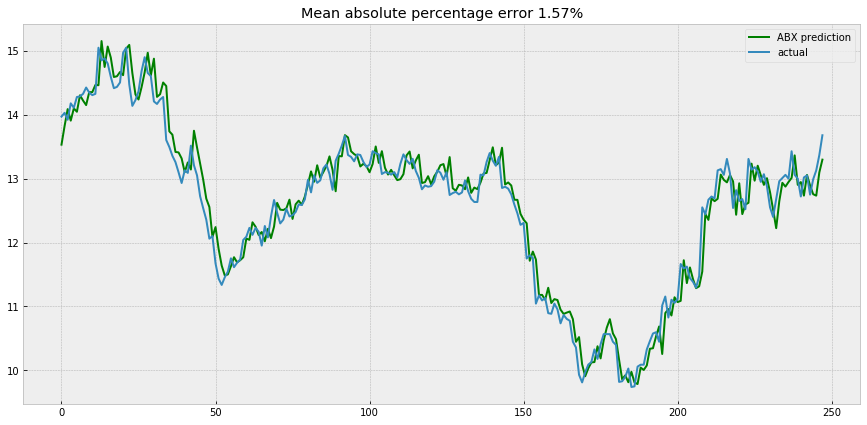

In [78]:
plotResults(ridge_ABX, X_ABX_test_scaled, y_ABX_test, figsize=(15, 7), asset_name='ABX')

#### 5.1.2 ABX Lasso

In [79]:
lasso_ABX = grid_search(estimator = Lasso(),
                      X=X_ABX_train_scaled, 
                      y=y_ABX_train,
                      grid_param=param_lasso,
                      cv=time_split)

Fitting 3 folds for each of 13 candidates, totalling 39 fits


[Parallel(n_jobs=-1)]: Done  39 out of  39 | elapsed:    0.2s finished


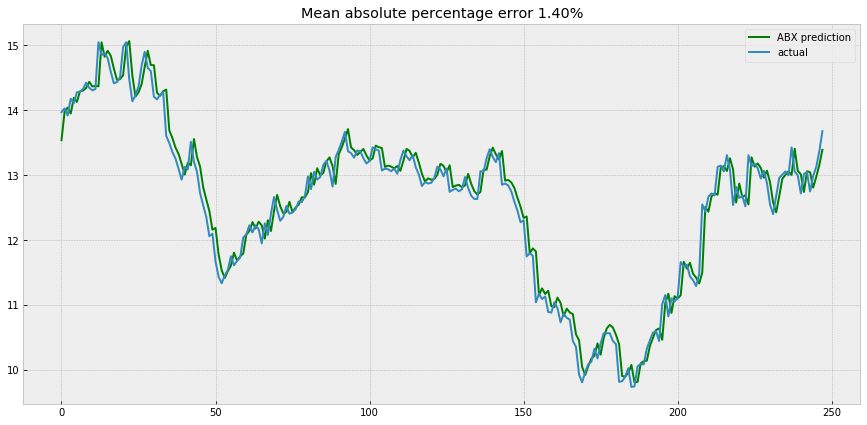

In [80]:
plotResults(lasso_ABX, X_ABX_test_scaled, y_ABX_test, figsize=(15, 7), asset_name='ABX')

---

#### 5.2 WMT predictions

In [81]:
X_WMT_train = prepareData(adj_close.WMT_Adj_close)
X_WMT_train_scaled, X_WMT_test_scaled, y_WMT_train, y_WMT_test = feature_scaling(adj_close.WMT_Adj_close)

In [82]:
[(el[0].shape, el[1].shape) for el in time_split.split(X_WMT_train_scaled)]

[((249,), (247,)), ((496,), (247,)), ((743,), (247,))]

#### 5.2.1 WMT Ridge

In [83]:
ridge_WMT = grid_search(estimator = Ridge(),
                      X=X_WMT_train_scaled, 
                      y=y_WMT_train,
                      grid_param=param_ridge, 
                      cv=time_split)

Fitting 3 folds for each of 13 candidates, totalling 39 fits


[Parallel(n_jobs=-1)]: Done  39 out of  39 | elapsed:    0.1s finished


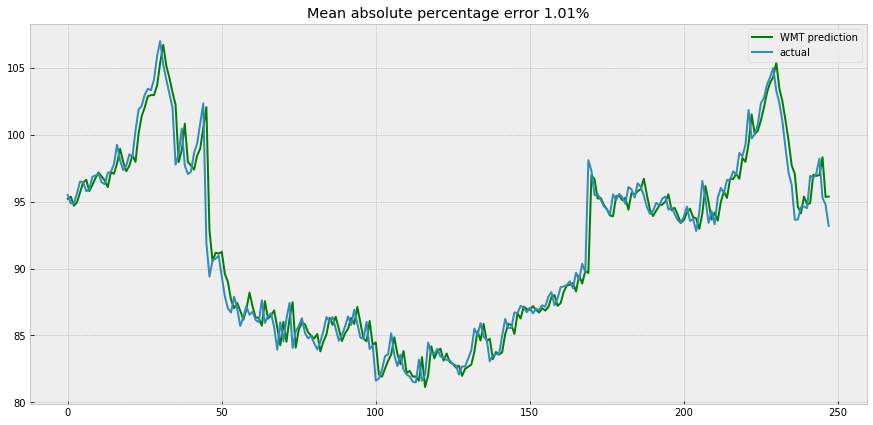

In [84]:
plotResults(ridge_WMT, X_WMT_test_scaled, y_WMT_test, figsize=(15, 7), asset_name='WMT')

#### 5.2.2 WMT Lasso

In [85]:
lasso_WMT = grid_search(estimator = Lasso(),
                      X=X_WMT_train_scaled, 
                      y=y_WMT_train,
                      grid_param=param_lasso, 
                      cv=time_split)

Fitting 3 folds for each of 13 candidates, totalling 39 fits


[Parallel(n_jobs=-1)]: Done  39 out of  39 | elapsed:    0.2s finished


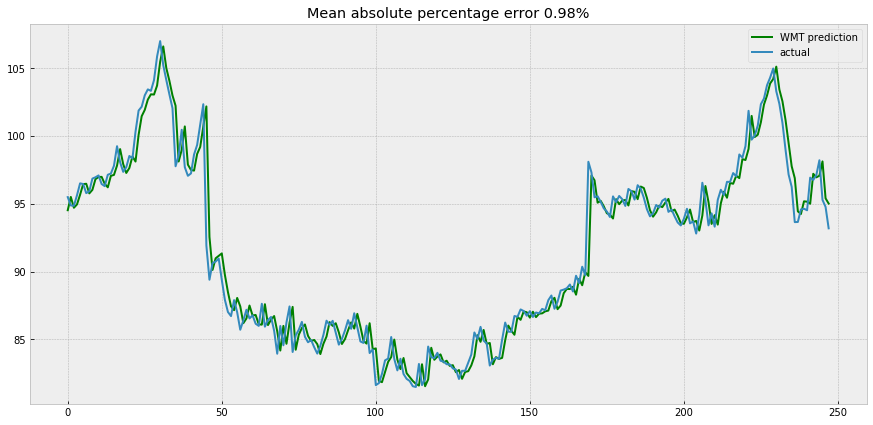

In [86]:
plotResults(lasso_WMT, X_WMT_test_scaled, y_WMT_test, figsize=(15, 7), asset_name='WMT')

#### 5.3 CAT predictions

In [87]:
X_CAT_train = prepareData(adj_close.CAT_Adj_close)
X_CAT_train_scaled, X_CAT_test_scaled, y_CAT_train, y_CAT_test = feature_scaling(adj_close.CAT_Adj_close)

In [88]:
[(el[0].shape, el[1].shape) for el in time_split.split(X_CAT_train_scaled)]

[((249,), (247,)), ((496,), (247,)), ((743,), (247,))]

#### 5.3.1 CAT Ridge

In [89]:
ridge_CAT = grid_search(estimator = Ridge(),
                      X=X_CAT_train_scaled, 
                      y=y_CAT_train,
                      grid_param=param_ridge, 
                      cv=time_split)

Fitting 3 folds for each of 13 candidates, totalling 39 fits


[Parallel(n_jobs=-1)]: Done  39 out of  39 | elapsed:    0.1s finished


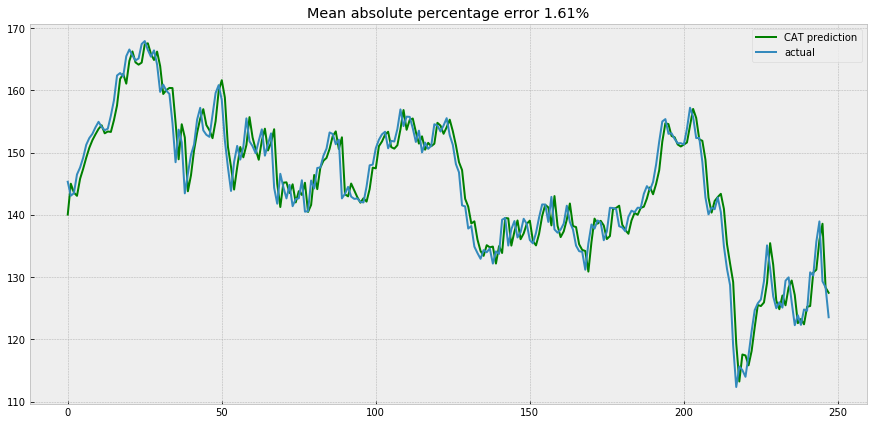

In [90]:
plotResults(ridge_CAT, X_CAT_test_scaled, y_CAT_test, figsize=(15, 7), asset_name='CAT')

#### 5.3.2 CAT Lasso

In [91]:
lasso_CAT = grid_search(estimator = Lasso(),
                      X=X_CAT_train_scaled, 
                      y=y_CAT_train,
                      grid_param=param_lasso,
                      cv=time_split)

Fitting 3 folds for each of 13 candidates, totalling 39 fits


[Parallel(n_jobs=-1)]: Done  39 out of  39 | elapsed:    0.1s finished


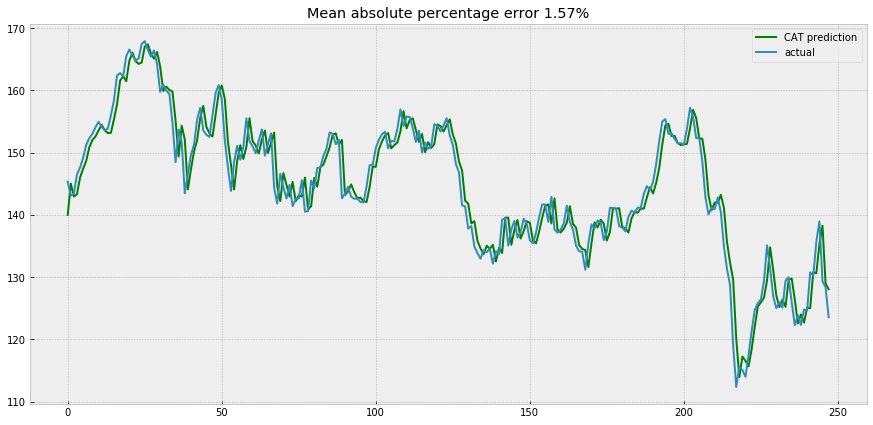

In [92]:
plotResults(lasso_CAT, X_CAT_test_scaled, y_CAT_test, figsize=(15, 7), asset_name='CAT')

### 5.4. BP predictions

In [93]:
X_BP_train = prepareData(adj_close.BP_Adj_close)
X_BP_train_scaled, X_BP_test_scaled, y_BP_train, y_BP_test = feature_scaling(adj_close.BP_Adj_close)

In [94]:
[(el[0].shape, el[1].shape) for el in time_split.split(X_CAT_train_scaled)]

[((249,), (247,)), ((496,), (247,)), ((743,), (247,))]

#### 5.4.1 BP Ridge

In [95]:
ridge_BP = grid_search(estimator = Ridge(),
                      X=X_BP_train_scaled, 
                      y=y_BP_train,
                      grid_param=param_ridge)

Fitting 3 folds for each of 13 candidates, totalling 39 fits


[Parallel(n_jobs=-1)]: Done  39 out of  39 | elapsed:    0.1s finished


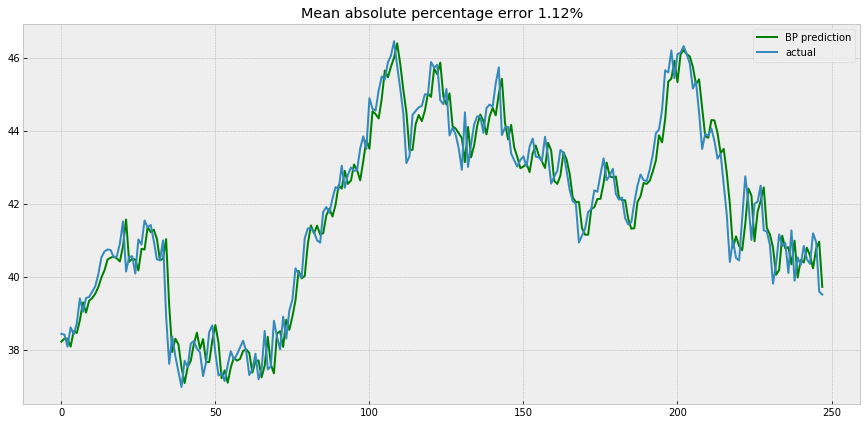

In [96]:
plotResults(ridge_BP, X_BP_test_scaled, y_BP_test, figsize=(15, 7), asset_name='BP')

#### 5.4.2 BP Lasso

In [97]:
lasso_BP = grid_search(estimator = Lasso(),
                      X=X_BP_train_scaled, 
                      y=y_BP_train,
                      grid_param=param_lasso,
                      cv=time_split)

Fitting 3 folds for each of 13 candidates, totalling 39 fits


[Parallel(n_jobs=-1)]: Done  39 out of  39 | elapsed:    0.1s finished


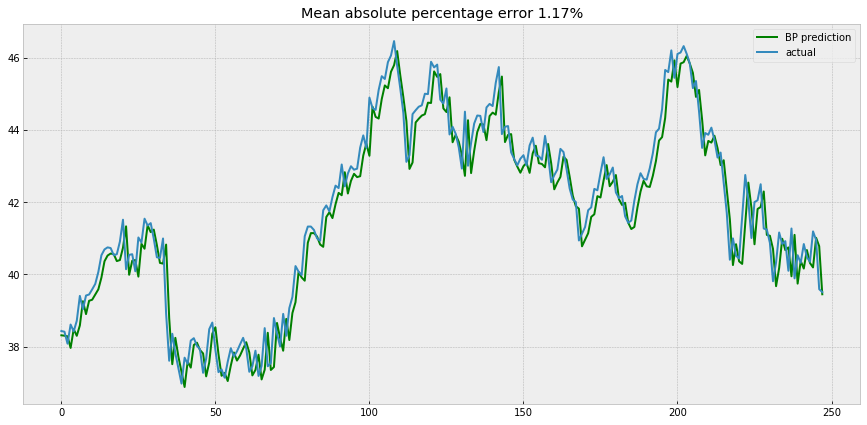

In [98]:
plotResults(lasso_BP, X_BP_test_scaled, y_BP_test, figsize=(15, 7), asset_name='BP')

### 5.5 F predictions

In [99]:
X_F_train = prepareData(adj_close.F_Adj_close)
X_F_train_scaled, X_F_test_scaled, y_F_train, y_F_test = feature_scaling(adj_close.F_Adj_close)

In [100]:
[(el[0].shape, el[1].shape) for el in time_split.split(X_F_train_scaled)]

[((249,), (247,)), ((496,), (247,)), ((743,), (247,))]

#### 5.5.1 F Ridge

In [101]:
ridge_F = grid_search(estimator = Ridge(),
                      X=X_F_train_scaled, 
                      y=y_F_train,
                      grid_param=param_ridge)

Fitting 3 folds for each of 13 candidates, totalling 39 fits


[Parallel(n_jobs=-1)]: Done  39 out of  39 | elapsed:    0.2s finished


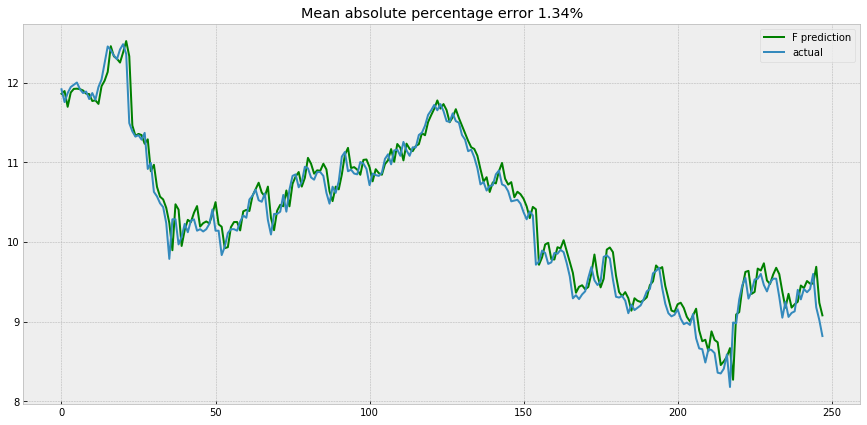

In [102]:
plotResults(ridge_F, X_F_test_scaled, y_F_test, figsize=(15, 7), asset_name='F')

#### 5.5.2 F Lasso

In [103]:
lasso_F = grid_search(estimator = Lasso(),
                      X=X_F_train_scaled, 
                      y=y_F_train,
                      grid_param=param_lasso,
                      cv=time_split)

Fitting 3 folds for each of 13 candidates, totalling 39 fits


[Parallel(n_jobs=-1)]: Done  39 out of  39 | elapsed:    0.1s finished


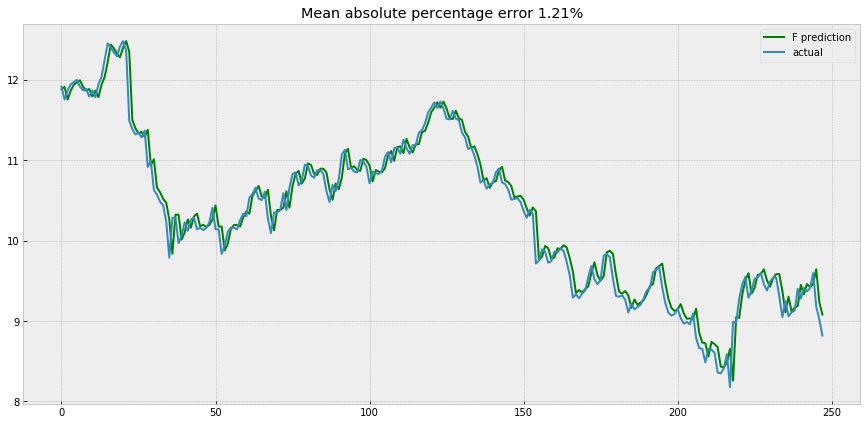

In [104]:
plotResults(lasso_F, X_F_test_scaled, y_F_test, figsize=(15, 7), asset_name='F')

### 5.6. GE predictions

In [105]:
X_GE_train = prepareData(adj_close.GE_Adj_close)
X_GE_train_scaled, X_GE_test_scaled, y_GE_train, y_GE_test = feature_scaling(adj_close.GE_Adj_close)

#### 5.6.1 GE Ridge

In [106]:
ridge_GE = grid_search(estimator = Ridge(),
                      X=X_GE_train_scaled, 
                      y=y_GE_train,
                      grid_param=param_ridge)

Fitting 3 folds for each of 13 candidates, totalling 39 fits


[Parallel(n_jobs=-1)]: Done  39 out of  39 | elapsed:    0.1s finished


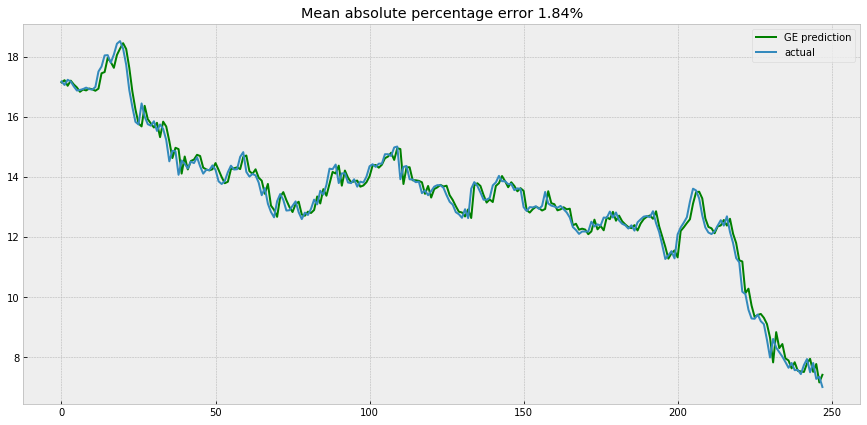

In [107]:
plotResults(ridge_GE, X_GE_test_scaled, y_GE_test, figsize=(15, 7), asset_name='GE')

#### 5.6.2 GE Lasso

In [108]:
lasso_GE = grid_search(estimator = Lasso(),
                      X=X_GE_train_scaled, 
                      y=y_GE_train,
                      grid_param=param_lasso,
                      cv=time_split)

Fitting 3 folds for each of 13 candidates, totalling 39 fits


[Parallel(n_jobs=-1)]: Done  39 out of  39 | elapsed:    0.1s finished


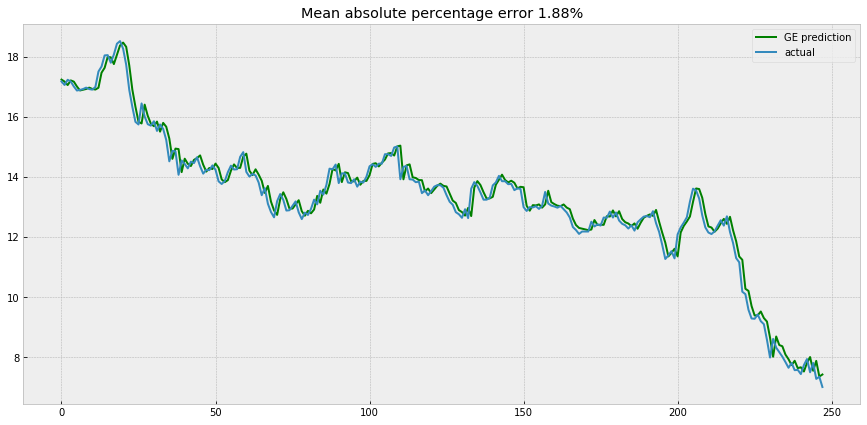

In [109]:
plotResults(lasso_GE, X_GE_test_scaled, y_GE_test, figsize=(15, 7), asset_name='GE')

## 6. Conclusion

In this project, we have provided a graphical analysis of United Continental Holdings Inc. (UAL), BP p.l.c. (BP), American Water Works Company Inc. (AWK), Ford Motor Company (F), General Electric Company (GE) and Walmart Inc. (WMT) returns as well as adjusted close prices. ARMA model has also been fit to the data individually to model returns as well as Ridge and Lasso ML algorithms have been applied to forecast prices. However, there are numerous ways to improve and strengthen the predictions.

1. Blending of ML algorithms to predict whether the price goes up or down. 
2. ARMA-GARCH simulteneous modelling should drastically improve the result since, as we discussed above, there are volatility clusted which cannot be encompassed by ARMA alone. However, if we simply apply GARCH to ARMA-residuals, the approach will not be self-consistent.
3. Robust feature tuning is required before applying ML algorithms. Open price can be added as an additional feature to predict adjusted close prices.
4. Additing additional features. One of possible ways to generate additional feature is to forecast adjusted close price of NASDAQ or S&P500 index, and use it as an extra input parameter while tuning ML algorithm.
5. Here 6 assets were individually modelled while they can be modelled together in order to improve the quality of predictions and reduce the overall of risk by building a portfolio. This project is the first step towards building and testing the performance of a porfolio based on these assets.
6. When analysis of extreme events is done and portfolio evaluation is made, one can suggest a trading strategy. At the moment, even though, according to mean absolute percentage metrics, our predictions may look good, if we use them as signal predictions, the results are not promising.